# Variogram analysis and kriging for data in 2D with non-stationarity

The goal is to interpolate a non-stationary data set in 2D (based on simple or ordinary kriging) in a domain (grid), where non-stationarity are given as
- local orientation, i.e. map of angle defining the orientation of the main axes of the covariance model,
- local factor (multiplier) for the ranges along the main axes of the covariance model,
- local factor (multiplier) for the total weight (variance, sill) of the covariance model.

One or several of these non-stationary features can be considered.

## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

# import package 'geone'
import geone as gn

In [2]:
# Show version of python and version of geone
import sys 
print(sys.version_info)
print('geone version: ' + gn.__version__)

sys.version_info(major=3, minor=11, micro=5, releaselevel='final', serial=0)
geone version: 1.2.3


## I. Build non-stationary features on a grid
Here are built the following non-stationary features on a grid:
- `alpha_loc`: local varying map of orientation (angle `alpha` = "minus mathematical angle in degrees") ), determining the orientation of the structures,
- `r_factor_loc`: local factor (multiplier) for the ranges along the main axes of the covariance model,
- `w_factor_loc`: local factor (multiplier) for the total weight (variance, sill) of the covariance model.

### Defining domain of simulation (grid)

In [3]:
nx, ny = 301, 161  # number of cells
sx, sy = 1.0, 1.0  # cell unit
ox, oy = -150.5, -80.5  # origin

xmin, xmax = ox, ox+nx*sx
ymin, ymax = oy, oy+ny*sy

# # Set an image with simulation grid geometry defined above, and no variable
# im = gn.img.Img(nx, ny, 1, sx, sy, 1., ox, oy, 0., nv=0)


### Defining non-stationary orientation
The angle `alpha` (= "minus mathematical angle in degrees") locally varying in the grid is defined as 
- `im_alpha`: an image (with one variable on the grid)
- `alpha_loc_func`: a function as a location (in the grid) (interpolating the values in the image, function built from image `im_alpha`)

#### How defining the orienation map (`im_alpha`)
The orientation map can be defined as follows:
1. Define a data set consisting in some points in the simulation area with angle (alpha) values attached
2. Krige the data set of alpha over the image grid

**Notes for point 1.**

When matplotlib is used with an interactive backend, the step 1. above can be done by interactively drawing segments ("paths of two points") using the function `geone.tools.add_path_by_drawing` as follows. 

1a. Initialize an empty list of segments:
```
seg_list = []
```
1b. Plot the simulation area and draw segments (paths with two points) according to desired orientations (update list `seg_list`):
```
plt.figure()
plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], ls='dashed', c='blue', alpha=.5)
plt.show()

seg_list = []
gn.tools.add_path_by_drawing(seg_list) # draw segments (follow the instructions)
```
1c. Then, retrieve the point locations and the `alpha` angles according to each segment:
```
points = np.vstack([seg[0] for seg in seg_list])
seg_vec_list = [seg[1]-seg[0] for seg in seg_list]
angles = -180.0/np.pi * np.hstack([np.arctan2(seg_vec[1], seg_vec[0]) for seg_vec in seg_vec_list])
```
If needed, add additional points and angles, by drawing additional segments: re-run the part 1b. and 1c. until satisfactory data set for orientation is obtained.

**Below:** another way to set points with angle (alpha) values is proposed.

1. Set some points with angle (alpha) values

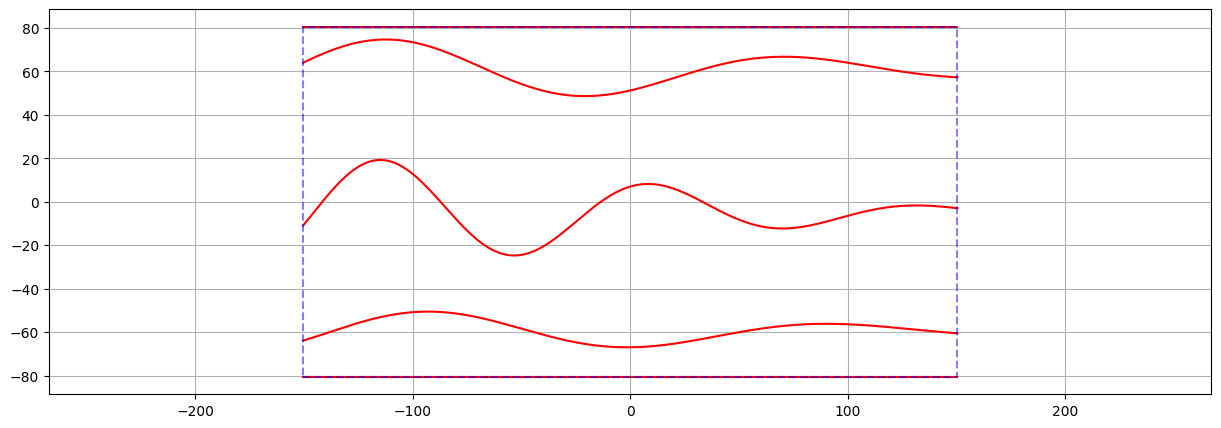

In [4]:
# Define three curves (crossing the grid)
x = np.linspace(xmin, xmax, 500)

# Curves from bottom to top
ycurve = []
y = ymin * np.ones_like(x)
ycurve.append(y)

u1, u2, u3, u4, u5, u6 = -60.0, 10.0, -150.0, 250.0, -50.0, 30.0
y = u1 + u2 * np.exp(-(((x-u3)/u4)**2)) * np.sin((u5 +x)/u6)
ycurve.append(y)

u1, u2, u3, u4, u5, u6 = -5.0, 25.0, -150.0, 200.0, 20.0, 20.0
y = u1 + u2 * np.exp(-(((x-u3)/u4)**2)) * np.sin((u5 +x)/u6)
ycurve.append(y)

u1, u2, u3, u4, u5, u6 = 60.0, 15.0, -150.0, 250.0, -30.0, 30.0
y = u1 + u2 * np.exp(-(((x-u3)/u4)**2)) * np.sin((u5 +x)/u6)
ycurve.append(y)

y = ymax * np.ones_like(x)
ycurve.append(y)

# Plot
plt.figure(figsize=(15,5))
for y in ycurve:
    plt.plot(x, y, c='red')
plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], ls='dashed', c='blue', alpha=.5)
plt.grid()
plt.axis('equal')
plt.show()

In [5]:
# Compute slope (derivate) along the curves and retrieve angles
#   angle: alpha = "minus mathematical angle in degrees"
acurve = [-np.arctan(np.diff(y)/np.diff(x))*180.0/np.pi for y in ycurve]

# Extract some points along the curves with the angles
jcurve = [np.arange(i0, len(acurve[i]), k) for i, (i0, k) in enumerate(zip([10, 5, 0, 7, 12], [50, 40, 30, 40, 50]))]
points = np.vstack([np.array((x[j], ycurve[i][j])).T for i, j in enumerate(jcurve)])
angles = np.hstack([acurve[i][j] for i, j in enumerate(jcurve)])

Plot the points with defined orientation.

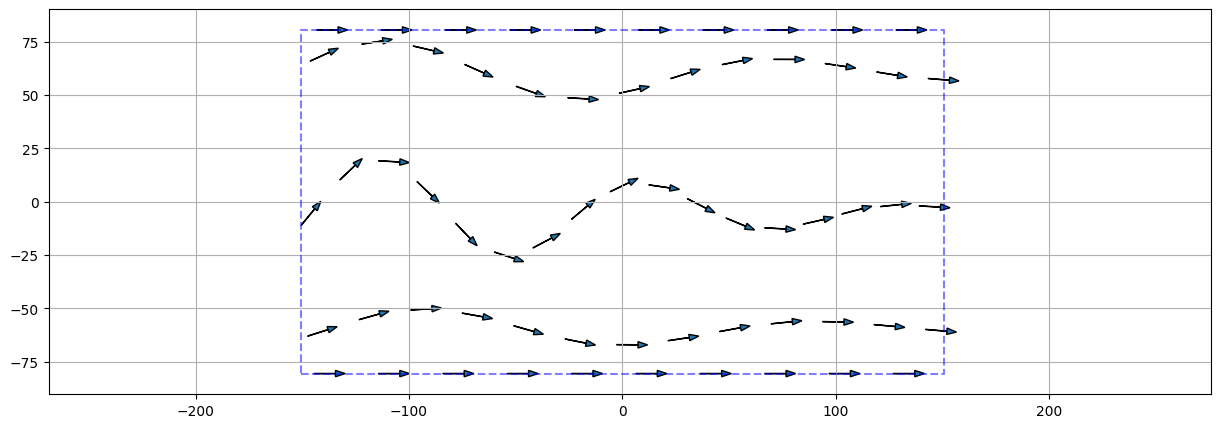

In [8]:
mrot = np.asarray([gn.covModel.rotationMatrix2D(ai) for ai in angles])
ax1 = mrot[:,:,0]

# Plot
plt.figure(figsize=(15,5))
vlen = 10.0
width = 0.1
head_width = 3.0
for p, a1 in zip(points, ax1):
    plt.arrow(p[0], p[1], vlen*a1[0], vlen*a1[1], width=width, head_width=head_width)
# for p, a in zip(points, angles):
#     plt.arrow(p[0], p[1], vlen*np.cos(-a*np.pi/180.0), vlen*np.sin(-a*np.pi/180.0), width=width, head_width=head_width)
plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], ls='dashed', c='blue', alpha=.5)
plt.grid()
plt.axis('equal')
plt.show()

2. Krige the data set of alpha over the image grid

Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20230914 / OpenMP 8 thread(s)]
Geos-Classic run complete


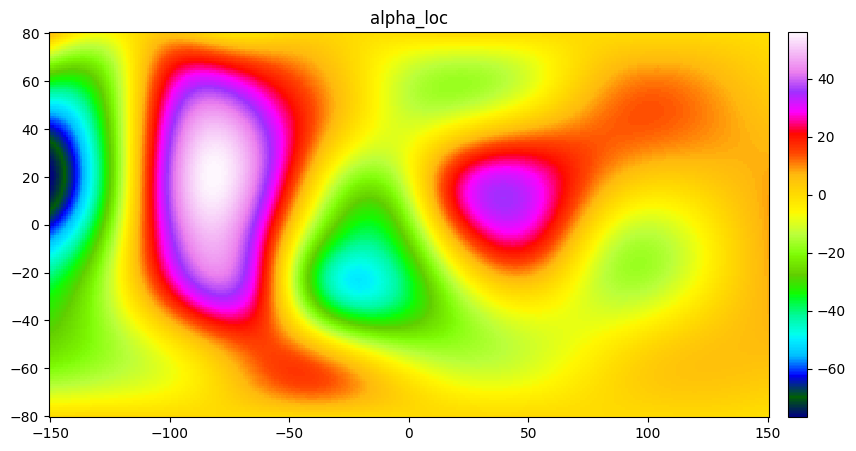

In [9]:
# Interpolate the angles in the grid (smooth interpolation) by kriging
cov_model_angles = gn.covModel.CovModel2D(elem=[
    ('matern', {'w':1.0, 'r':[100, 80], 'nu':3.0}), # elementary contribution
    ], alpha=0.0, name='')

out = gn.geosclassicinterface.estimate2D(cov_model_angles, (nx, ny), (sx, sy), (ox, oy), 
                                         x=points, v=angles, method='simple_kriging',
                                         use_unique_neighborhood=True, nthreads=8)
im_alpha = out['image']

plt.figure(figsize=(15,5))
gn.imgplot.drawImage2D(im_alpha, iv=0, cmap='gist_ncar')
plt.title('alpha_loc')
plt.show()

In [10]:
# Set a function interpolating the value of the angle (given location)
alpha_loc_func = gn.img.Img_interp_func(im_alpha, ind=0, iz=0) # Specify iz=0: consider only x, and y coordinates in the layer iz=0

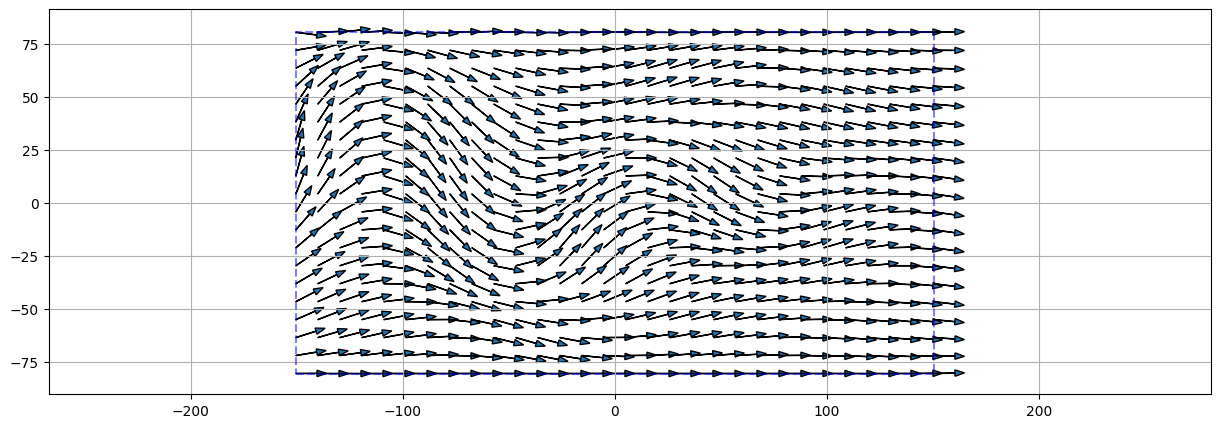

In [11]:
# Show the direction according to the angles alpha in some points of the grid
x1 = np.linspace(im_alpha.xmin(), im_alpha.xmax(), 30)
x2 = np.linspace(im_alpha.ymin(), im_alpha.ymax(), 20)

xx2, xx1 = np.meshgrid(x2, x1, indexing='ij')

points = np.array((xx1.reshape(-1), xx2.reshape(-1))).T
angles = alpha_loc_func(points)
mrot = np.asarray([gn.covModel.rotationMatrix2D(ai) for ai in angles])
ax1 = mrot[:,:,0]
#ax2 = mrot[:,:,1]

# Plot
plt.figure(figsize=(15,5))
vlen = 10.0
width = 0.1
head_width = 3.0
for p, a1 in zip(points, ax1):
    plt.arrow(p[0], p[1], vlen*a1[0], vlen*a1[1], width=width, head_width=head_width)
# for p, a in zip(points, angles):
#     plt.arrow(p[0], p[1], vlen*np.cos(-a*np.pi/180.0), vlen*np.sin(-a*np.pi/180.0), width=width, head_width=head_width)
plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], ls='dashed', c='blue', alpha=.5)
plt.grid()
plt.axis('equal')
plt.show()

### Defining non-stationary ranges
The factor (multiplier) for range `r_factor` locally varying in the grid is defined as `im_r_factor`: an image (with one variable on the grid).

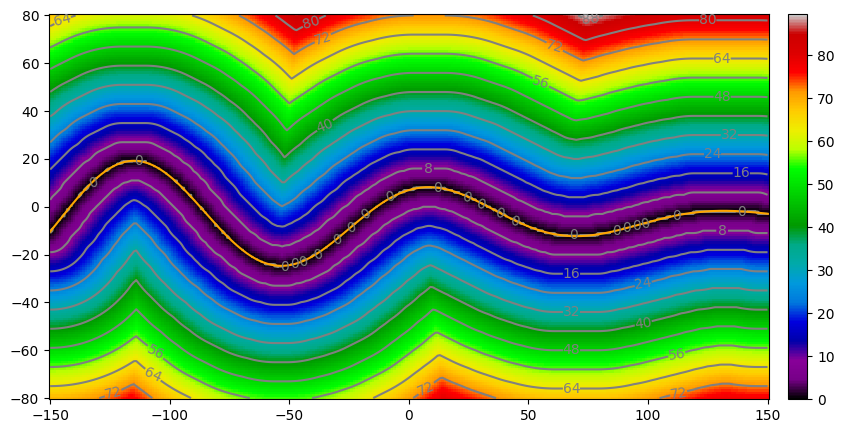

In [10]:
# Compute distance to the middle curve (x, ycurve[2]) above
im_line = gn.img.imageFromPoints(np.array((x, ycurve[2])).T, nx=nx, ny=ny, sx=sx, sy=sy, ox=ox, oy=oy, indicator_var=True)
im_line_dist = gn.geosclassicinterface.imgDistanceImage(im_line, distance_type='L2')

# Plot
plt.figure(figsize=(15,5))
gn.imgplot.drawImage2D(im_line_dist, cmap='nipy_spectral', levels=12, contour=True, contour_clabel=True)
plt.plot(x, ycurve[2], color='orange')
plt.show()

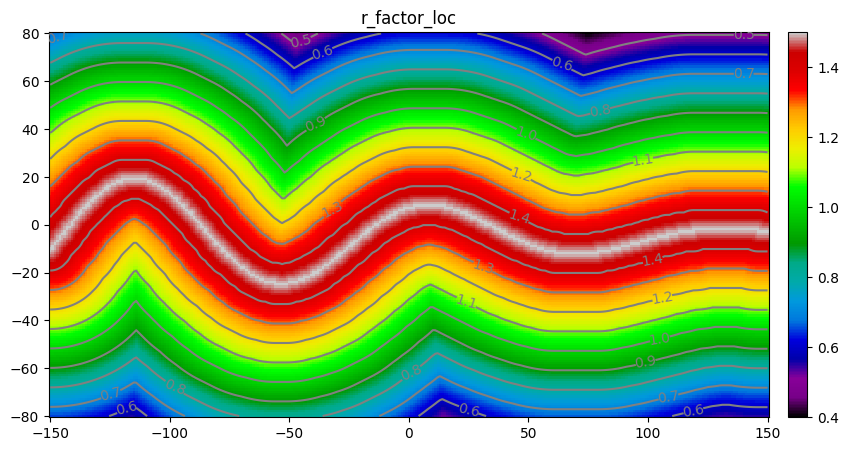

In [11]:
# Define r_factor as r0 on the middle curve and decreasing linearly wrt the distance above
r0 = 1.5 # on the middle curve
r1 = 0.4 # minimal value
d = im_line_dist.val[0] # distance map
r = r0 + d/d.max() * (r1-r0)

im_r_factor = gn.img.copyImg(im_line_dist)
im_r_factor.val = r0 + im_r_factor.val/im_r_factor.val.max() * (r1-r0)

# Plot
plt.figure(figsize=(15,5))
gn.imgplot.drawImage2D(im_r_factor, cmap='nipy_spectral', levels=12, contour=True, contour_clabel=True)
plt.title('r_factor_loc')
plt.show()

### Defining non-stationary variance (sill)
The factor (multiplier) for the total weight (variance, sill) `w_factor` locally varying in the grid is defined as `im_w_factor`: an image (with one variable on the grid).

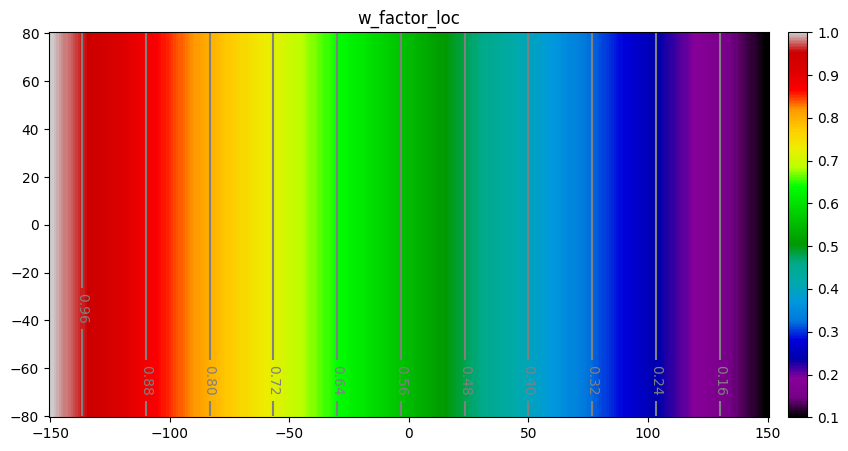

In [12]:
# Define w_factor as w0 on the left of the grid and decreasing linearly when going to the right of the grid
w0 = 1.0 # on the left
w1 = 0.1 # minimal value

# "Empty" image
im_w_factor = gn.img.Img(nx, ny, 1, sx, sy, 1., ox, oy, 0., nv=0)

# Add variable
w = w0 + (im_w_factor.xx()-im_w_factor.xx().min())/(im_w_factor.xx().max()-im_w_factor.xx().min()) * (w1-w0)
im_w_factor.append_var(w)

# Plot
plt.figure(figsize=(15,5))
gn.imgplot.drawImage2D(im_w_factor, cmap='nipy_spectral', levels=12, contour=True, contour_clabel=True)
plt.title('w_factor_loc')
plt.show()

## II Non-stationary simulations
First define a reference covariance model and generate an unconditional simulation (reference). Then build a data set by extract some points from the simulation. Then, ignoring the covariance model and starting from the data set and the maps controlling the non-stationary features:
- fit a covariance model,
- do kriging / conditional simulations

Several cases are proposed below with different non-stationary features.

## A. Non-stationary orientation

### Reference covariance model and non-stationarity
Define first a *stationary* anisotropic reference covariance model in 2D. Then, add the desired non-stationarity feature.

In [13]:
# Define a reference covariance model (stationary)
cov_model_ref = gn.covModel.CovModel2D(elem=[
    ('cubic', {'w':10, 'r':[30., 5.]}), # elementary contribution
    ], alpha=0.0, name='ref')

# Define the reference non-stationary covariance model
#   - Set locally varying angle: alpha in the grid
cov_model_loc_ref = gn.covModel.copyCovModel(cov_model_ref)
cov_model_loc_ref.set_alpha(im_alpha.val[0])

### Do an unconditional simulation (reference)

Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20230914 / OpenMP 8 thread(s)]
Geos-Classic run complete

Warnings encountered (31 times in all):
#  1: WARNING 02001: a neigbhor has been dropped (solving kriging system)


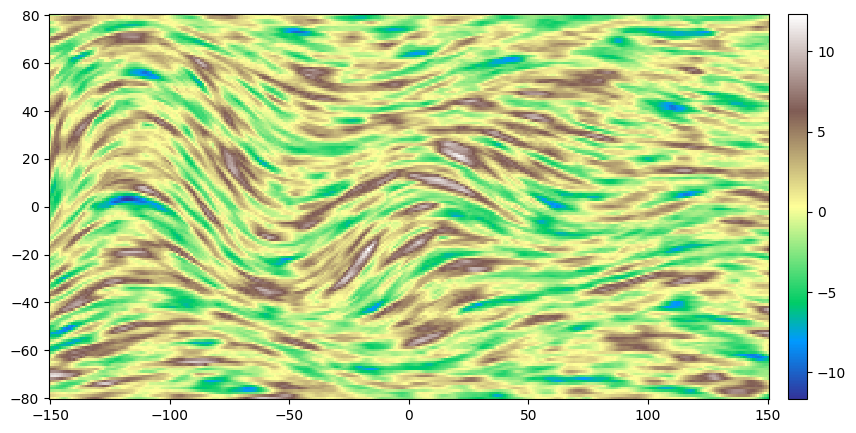

In [14]:
# Simulation
nreal = 1
np.random.seed(32)
geosclassic_output = gn.geosclassicinterface.simulate2D(cov_model_loc_ref, (nx, ny), (sx, sy), (ox, oy), 
                                                        method='simple_kriging', nneighborMax=20, nreal=nreal, 
                                                        nthreads=8)

im_ref = geosclassic_output['image']

plt.figure(figsize=(15,5))
gn.imgplot.drawImage2D(im_ref, cmap='terrain')
plt.show()

### Build a non-stationary data set (2D)

The data set is defined by extracting some points from the simulation of reference.

*Note:* the data set should contain enough points to catch the non-stationarities.

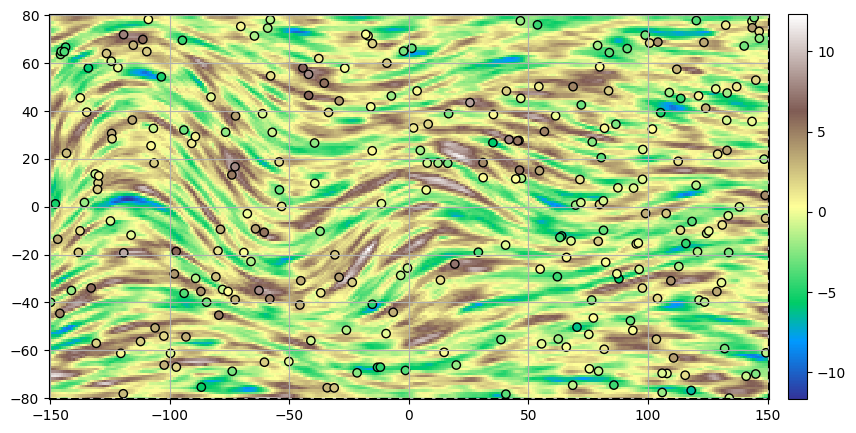

In [15]:
# Extract som points from the simulation
n = 280

# --- Choose 1. or 2. below ---
# # 1. Sampling the image
# ps = gn.img.sampleFromImage(im_ref, n, seed=234)
# # Data points and data value
# x = np.array((ps.x(), ps.y())).T
# v = ps.val[3]
# # Optionally: move points in the grid cells randomly, and add noise to values
# x[:, 0] = x[:, 0] + (np.random.random(n)-0.5)* im_ref.sx
# x[:, 1] = x[:, 1] + (np.random.random(n)-0.5)* im_ref.sy
# v = v + (np.random.random(n)-0.5)* 1.e-1

# 2. Using the function interpolating the image values
f = gn.img.Img_interp_func(im_ref, iz=0)
np.random.seed(658)
x1 = im_ref.xmin() + np.random.random(n) * (im_ref.xmax()-im_ref.xmin())
x2 = im_ref.ymin() + np.random.random(n) * (im_ref.ymax()-im_ref.ymin())
x = np.array((x1, x2)).T
v = f(x)
# ----- #

plt.figure(figsize=(15,5))
gn.imgplot.drawImage2D(im_ref, cmap='terrain')

plt.scatter(x[:,0], x[:,1], c=v, edgecolors='black', cmap='terrain', vmin=im_ref.vmin()[0], vmax=im_ref.vmax()[0])
plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], ls='dashed', c='black')
#plt.colorbar()
plt.axis('equal')
plt.grid()
plt.show()

### Simulation starting from a non-stationary data set in 2D and assuming "non-stationarity feature(s)" known
- `n`: number of data points,
- `x`: location of data points (2-dimensional array of shape `(n, 2)`, each row is a point),
- `v`: values at data points (1-dimensional array of length `n`),
- `im_alpha`: image of the angle `alpha` in the grid; the function `alpha_loc_func` (interpolator of `alpha` in the grid) is built from this image.

In [16]:
# Set a function interpolating the alpha (given location)
alpha_loc_func = gn.img.Img_interp_func(im_alpha, ind=0, iz=0) # Specify iz=0: consider only x, and y coordinates in the layer iz=0

### Fitting covariance model accounting for non-stationarity

In [17]:
cov_model_to_optimize = gn.covModel.CovModel2D(elem=[
        ('cubic', {'w':np.nan, 'r':[np.nan, np.nan]}), # elementary contribution
         ], alpha=0.0, name='') # alpha is set to 0.0, non-sationarity is handled by alpha_loc_func below

t1 = time.time()
cov_model_opt, popt = gn.covModel.covModel2D_fit(x, v, cov_model_to_optimize, 
                alpha_loc_func=alpha_loc_func, # deal with non-stationarity (angle alpha)
                loc_m=0, # loc_m > 0: number of sub-intervals btw pair of points to estimate local function (default 1)
                         # loc_m = 0: take factor from one point
                bounds=([ 0,  0,  0],  # min value for param. to fit
                        [40, 80, 80]), # max value for param. to fit
                hmax=None, make_plot=False) # figure size for plot
t2 = time.time()
print(f'Fitting covariance model - elapsed time: {t2-t1:.4g}')

cov_model_opt

Fitting covariance model - elapsed time: 0.127


*** CovModel2D object ***
name = ''
number of elementary contribution(s): 1
elementary contribution 0
    type: cubic
    parameters:
        w = 9.438974888330232
        r = [32.48013222064416, 5.723117063830401]
angle: alpha = 0.0 deg.
    i.e.: the system Ox'y', supporting the axes of the model (ranges),
    is obtained from the system Oxy by applying a rotation of angle -alpha.
*****

### Show experimental variogram, fitted model and reference model

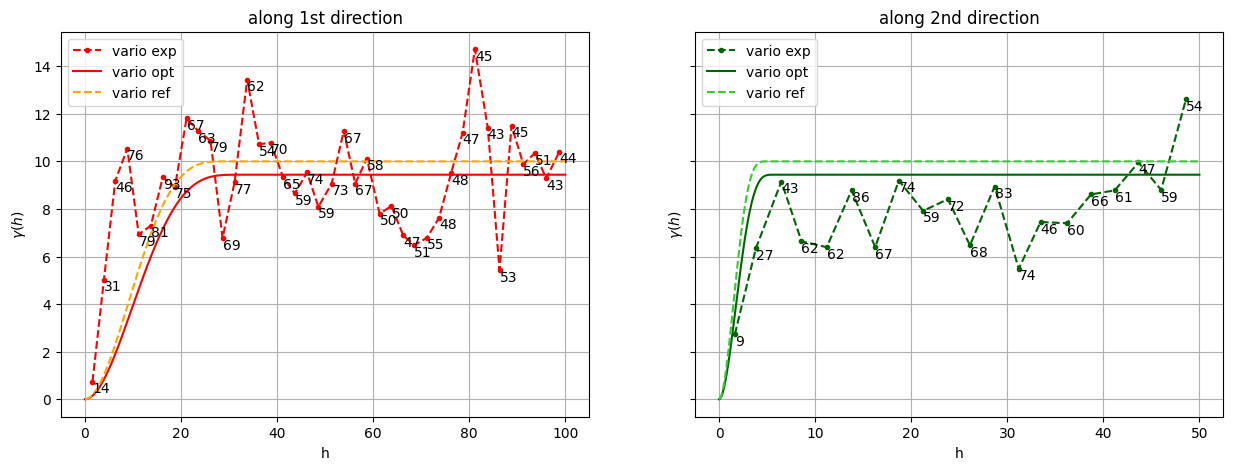

In [18]:
hmax1, hmax2 = 100.0, 50.0

(hexp1, gexp1, cexp1), (hexp2, gexp2, cexp2) = gn.covModel.variogramExp2D(
                x, v, alpha=0, hmax=(hmax1, hmax2), 
                alpha_loc_func=alpha_loc_func, loc_m=0,
                ncla=(40, 20), make_plot=False)

plt.subplots(1,2, sharey=True, figsize=(15,5))
plt.subplot(1,2,1)
gn.covModel.plot_variogramExp1D(hexp1, gexp1, cexp1, c='red', label='vario exp')
cov_model_opt.plot_model_one_curve(vario=True, main_axis=1, hmax=hmax1, c='red', label='vario opt')
cov_model_ref.plot_model_one_curve(vario=True, main_axis=1, hmax=hmax1, c='orange', ls='dashed', label='vario ref')
plt.legend()
plt.title("along 1st direction")

plt.subplot(1,2,2)
gn.covModel.plot_variogramExp1D(hexp2, gexp2, cexp2, c='darkgreen', label='vario exp')
cov_model_opt.plot_model_one_curve(vario=True, main_axis=2, hmax=hmax2, c='darkgreen', label='vario opt')
cov_model_ref.plot_model_one_curve(vario=True, main_axis=2, hmax=hmax2, c='limegreen', ls='dashed', label='vario ref')
plt.legend()
plt.title("along 2nd direction")

plt.show()

### Set non-stationarity covariance model

In [19]:
# Define the non-stationary covariance model
cov_model_loc_opt = gn.covModel.copyCovModel(cov_model_opt)
cov_model_loc_opt.set_alpha(im_alpha.val[0])

### Kriging and conditional simulations

In [20]:
# Kriging
t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.estimate2D(cov_model_loc_opt, (nx, ny), (sx, sy), (ox, oy), 
                                                        x=x, v=v, method='simple_kriging', nneighborMax=20, 
                                                        nthreads=8)
t2 = time.time() # end time
print(f'Kriging - elapsed time: {t2-t1:.4g} sec')

# Retrieve kriging estimate and standard deviation
im_krig = geosclassic_output['image']

Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20230914 / OpenMP 8 thread(s)]
Geos-Classic run complete

Warnings encountered (2192 times in all):
#  1: WARNING 00041: conditioning value(s) has(have) been ignored from data point set (more than one datum in the same simulation grid node!)
#  2: WARNING 02001: a neigbhor has been dropped (solving kriging system)
Kriging - elapsed time: 0.1212 sec


In [21]:
# Simulation
nreal = 50
np.random.seed(22131)
t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.simulate2D_mp(cov_model_loc_opt, (nx, ny), (sx, sy), (ox, oy), 
                                                           x=x, v=v, method='simple_kriging', nneighborMax=20, nreal=nreal,
                                                           nproc=4, nthreads_per_proc=4)
t2 = time.time() # end time
print(f'{nreal} simul. - elapsed time: {t2-t1:.4g} sec')

# Retrieve the realizations
simul = geosclassic_output['image']

# Compute mean and standard deviation (pixel-wise)
simul_mean = gn.img.imageContStat(simul, op='mean')
simul_std = gn.img.imageContStat(simul, op='std')

Geos-Classic running on 4 process(es)... [VERSION 2.0 / BUILD NUMBER 20230914 / OpenMP 4 thread(s)]
Geos-Classic run complete (all process(es))

Warnings encountered (520 times in all):
#  1: WARNING 00041: conditioning value(s) has(have) been ignored from data point set (more than one datum in the same simulation grid node!)
#  2: WARNING 02001: a neigbhor has been dropped (solving kriging system)
50 simul. - elapsed time: 7.255 sec


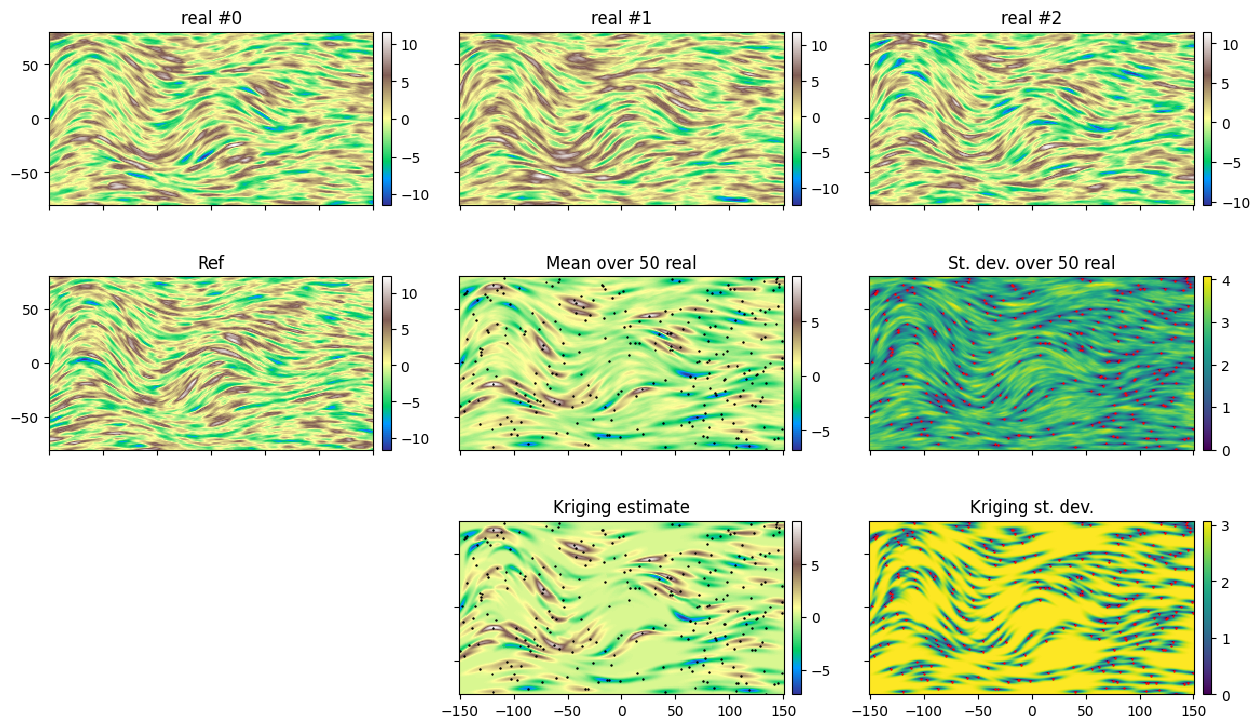

In [22]:
cmap = 'terrain'

# Plot
fig, ax = plt.subplots(3, 3, figsize=(15, 9), sharex=True, sharey=True)

# 3 first real ...
for i in (0, 1, 2):
    plt.subplot(3, 3, i+1)
    gn.imgplot.drawImage2D(simul, iv=i, cmap=cmap)
    #plt.plot(x[:,0],x[:,1], '+', c='black', markersize=10) # add conditioning point locations
    plt.title('real #{}'.format(i))

# ref 
plt.subplot(3, 3, 4)
gn.imgplot.drawImage2D(im_ref, cmap=cmap)
#plt.plot(x[:,0],x[:,1], '+', c='black', markersize=10) # add conditioning point locations
plt.title('Ref')

# mean of all real
plt.subplot(3, 3, 5)
gn.imgplot.drawImage2D(simul_mean, cmap=cmap)
plt.plot(x[:,0],x[:,1], '+', c='black', markersize=2) # add conditioning point locations
plt.title('Mean over {} real'.format(nreal))

# standard deviation of all real
plt.subplot(3, 3, 6)
gn.imgplot.drawImage2D(simul_std, cmap='viridis')
plt.plot(x[:,0],x[:,1], '+', c='red', markersize=2) # add conditioning point locations
plt.title('St. dev. over {} real'.format(nreal))

plt.subplot(3, 3, 7)
plt.axis('off')

# kriging estimate
plt.subplot(3, 3, 8)
gn.imgplot.drawImage2D(im_krig, iv=0, cmap=cmap)
plt.plot(x[:,0],x[:,1], '+', c='black', markersize=2) # add conditioning point locations
plt.title('Kriging estimate')

# kriging standard deviation
plt.subplot(3, 3, 9)
gn.imgplot.drawImage2D(im_krig, iv=1, cmap='viridis')
plt.plot(x[:,0],x[:,1], '+', c='red', markersize=2) # add conditioning point locations
plt.title('Kriging st. dev.')

plt.show()

## B1. Non-stationary range along each axis

### Reference covariance model and non-stationarity
Define first a *stationary* anisotropic reference covariance model in 2D. Then, add the desired non-stationarity feature.

In [23]:
# Define a reference covariance model (stationary)
cov_model_ref = gn.covModel.CovModel2D(elem=[
    ('cubic', {'w':10, 'r':[30., 5.]}), # elementary contribution
    ], alpha=0.0, name='ref')

# Define the reference non-stationary covariance model
#   - Set locally varying ranges: range factor in the grid
cov_model_loc_ref = gn.covModel.copyCovModel(cov_model_ref)
cov_model_loc_ref.multiply_r(im_r_factor.val[0], r_ind=(0, 1)) # range along each axis and of every contribution will be multiplied

### Do an unconditional simulation (reference)

Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20230914 / OpenMP 8 thread(s)]
Geos-Classic run complete

Warnings encountered (7 times in all):
#  1: WARNING 02001: a neigbhor has been dropped (solving kriging system)


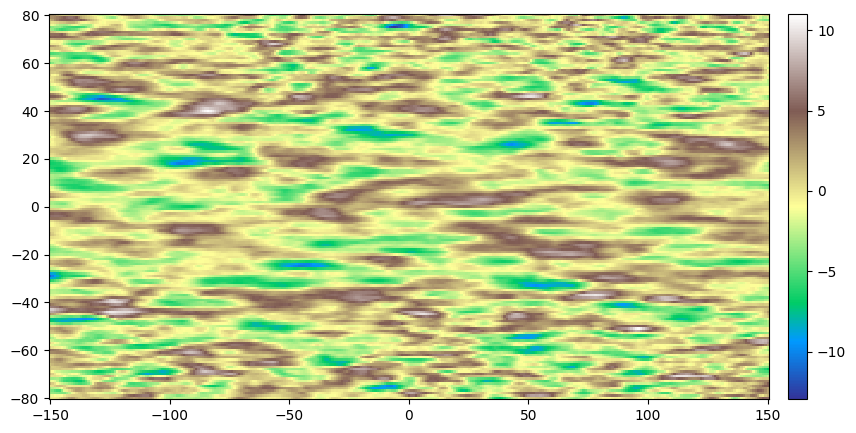

In [24]:
# Simulation
nreal = 1
np.random.seed(85)
geosclassic_output = gn.geosclassicinterface.simulate2D(cov_model_loc_ref, (nx, ny), (sx, sy), (ox, oy), 
                                                        method='simple_kriging', nneighborMax=20, nreal=nreal, 
                                                        nthreads=8)

im_ref = geosclassic_output['image']

plt.figure(figsize=(15,5))
gn.imgplot.drawImage2D(im_ref, cmap='terrain')
plt.show()

### Build a non-stationary data set (2D)

The data set is defined by extracting some points from the simulation of reference.

*Note:* the data set should contain enough points to catch the non-stationarities.

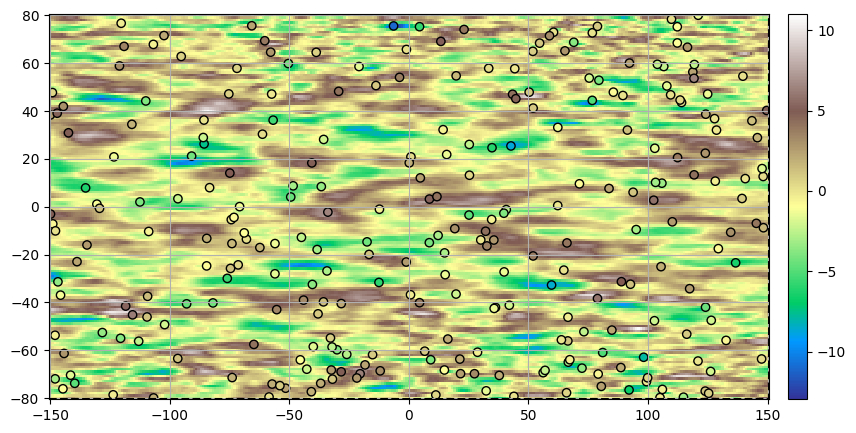

In [25]:
# Extract som points from the simulation
n = 280

# --- Choose 1. or 2. below ---
# # 1. Sampling the image
# ps = gn.img.sampleFromImage(im_ref, n, seed=234)
# # Data points and data value
# x = np.array((ps.x(), ps.y())).T
# v = ps.val[3]
# # Optionally: move points in the grid cells randomly, and add noise to values
# x[:, 0] = x[:, 0] + (np.random.random(n)-0.5)* im_ref.sx
# x[:, 1] = x[:, 1] + (np.random.random(n)-0.5)* im_ref.sy
# v = v + (np.random.random(n)-0.5)* 1.e-1

# 2. Using the function interpolating the image values
f = gn.img.Img_interp_func(im_ref, iz=0)
np.random.seed(987)
x1 = im_ref.xmin() + np.random.random(n) * (im_ref.xmax()-im_ref.xmin())
x2 = im_ref.ymin() + np.random.random(n) * (im_ref.ymax()-im_ref.ymin())
x = np.array((x1, x2)).T
v = f(x)
# ----- #

plt.figure(figsize=(15,5))
gn.imgplot.drawImage2D(im_ref, cmap='terrain')

plt.scatter(x[:,0], x[:,1], c=v, edgecolors='black', cmap='terrain', vmin=im_ref.vmin()[0], vmax=im_ref.vmax()[0])
plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], ls='dashed', c='black')
#plt.colorbar()
plt.axis('equal')
plt.grid()
plt.show()

### Simulation starting from a non-stationary data set in 2D and assuming "non-stationarity feature(s)" known
- `n`: number of data points,
- `x`: location of data points (2-dimensional array of shape `(n, 2)`, each row is a point),
- `v`: values at data points (1-dimensional array of length `n`),
- `im_r_factor`: image of the factor (multiplier) `r_factor` in the grid; the function `r_factor_inv_loc_func` (interpolator of the inverse of `r_factor` in the grid) is built from this image.

In [26]:
# Set a function interpolating the inverse of the r_factor (given location)
im_tmp = gn.img.copyImg(im_r_factor)
im_tmp.val = 1.0/im_tmp.val
r_factor_inv_loc_func = gn.img.Img_interp_func(im_tmp, ind=0, iz=0) # Specify iz=0: consider only x, and y coordinates in the layer iz=0

### Fitting covariance model accounting for non-stationarity

In [27]:
cov_model_to_optimize = gn.covModel.CovModel2D(elem=[
        ('cubic', {'w':np.nan, 'r':[np.nan, np.nan]}), # elementary contribution
         ], alpha=0.0, name='')

t1 = time.time()
cov_model_opt, popt = gn.covModel.covModel2D_fit(x, v, cov_model_to_optimize, 
                coord1_factor_loc_func=r_factor_inv_loc_func, coord2_factor_loc_func=r_factor_inv_loc_func, 
                                                 # deal with non-stationarity (multiplier for range along each axis)
                loc_m=0, # loc_m > 0: number of sub-intervals btw pair of points to estimate local function (default 1)
                         # loc_m = 0: take factor from one point
                bounds=([ 0,  0,  0],  # min value for param. to fit
                        [40, 80, 80]), # max value for param. to fit
                hmax=None, make_plot=False) # figure size for plot
t2 = time.time()
print(f'Fitting covariance model - elapsed time: {t2-t1:.4g}')

cov_model_opt

Fitting covariance model - elapsed time: 0.05393


*** CovModel2D object ***
name = ''
number of elementary contribution(s): 1
elementary contribution 0
    type: cubic
    parameters:
        w = 9.231318050346282
        r = [30.86385237987417, 8.578189473997803]
angle: alpha = 0.0 deg.
    i.e.: the system Ox'y', supporting the axes of the model (ranges),
    is obtained from the system Oxy by applying a rotation of angle -alpha.
*****

### Show experimental variogram, fitted model and reference model

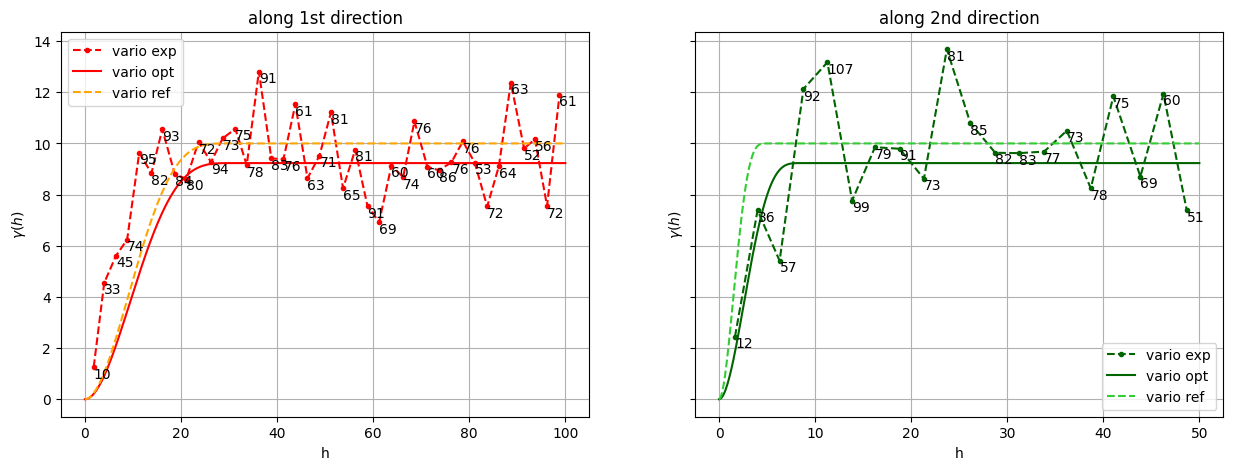

In [28]:
hmax1, hmax2 = 100.0, 50.0

(hexp1, gexp1, cexp1), (hexp2, gexp2, cexp2) = gn.covModel.variogramExp2D(
            x, v, alpha=0, hmax=(hmax1, hmax2),
            coord1_factor_loc_func=r_factor_inv_loc_func, coord2_factor_loc_func=r_factor_inv_loc_func,  loc_m=0,
            ncla=(40, 20), make_plot=False)

plt.subplots(1,2, sharey=True, figsize=(15,5))
plt.subplot(1,2,1)
gn.covModel.plot_variogramExp1D(hexp1, gexp1, cexp1, c='red', label='vario exp')
cov_model_opt.plot_model_one_curve(vario=True, main_axis=1, hmax=hmax1, c='red', label='vario opt')
cov_model_ref.plot_model_one_curve(vario=True, main_axis=1, hmax=hmax1, c='orange', ls='dashed', label='vario ref')
plt.legend()
plt.title("along 1st direction")

plt.subplot(1,2,2)
gn.covModel.plot_variogramExp1D(hexp2, gexp2, cexp2, c='darkgreen', label='vario exp')
cov_model_opt.plot_model_one_curve(vario=True, main_axis=2, hmax=hmax2, c='darkgreen', label='vario opt')
cov_model_ref.plot_model_one_curve(vario=True, main_axis=2, hmax=hmax2, c='limegreen', ls='dashed', label='vario ref')
plt.legend()
plt.title("along 2nd direction")

plt.show()

### Set non-stationarity covariance model

In [29]:
# Define the non-stationary covariance model
cov_model_loc_opt = gn.covModel.copyCovModel(cov_model_opt)
cov_model_loc_opt.multiply_r(im_r_factor.val[0], r_ind=(0, 1))

### Kriging and conditional simulations

In [30]:
# Kriging
t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.estimate2D(cov_model_loc_opt, (nx, ny), (sx, sy), (ox, oy), 
                                                        x=x, v=v, method='simple_kriging', nneighborMax=20,
                                                        nthreads=8)
t2 = time.time() # end time
print(f'Kriging - elapsed time: {t2-t1:.4g} sec')

# Retrieve kriging estimate and standard deviation
im_krig = geosclassic_output['image']

Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20230914 / OpenMP 8 thread(s)]
Geos-Classic run complete

Warnings encountered (813 times in all):
#  1: WARNING 02001: a neigbhor has been dropped (solving kriging system)
Kriging - elapsed time: 0.0591 sec


In [31]:
# Simulation
nreal = 50
np.random.seed(22131)
t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.simulate2D_mp(cov_model_loc_opt, (nx, ny), (sx, sy), (ox, oy), 
                                                           x=x, v=v, method='simple_kriging', nneighborMax=20, nreal=nreal,
                                                           nproc=4, nthreads_per_proc=4)
t2 = time.time() # end time
print(f'{nreal} simul. - elapsed time: {t2-t1:.4g} sec')

# Retrieve the realizations
simul = geosclassic_output['image']

# Compute mean and standard deviation (pixel-wise)
simul_mean = gn.img.imageContStat(simul, op='mean')
simul_std = gn.img.imageContStat(simul, op='std')

Geos-Classic running on 4 process(es)... [VERSION 2.0 / BUILD NUMBER 20230914 / OpenMP 4 thread(s)]
Geos-Classic run complete (all process(es))

Warnings encountered (410 times in all):
#  1: WARNING 02001: a neigbhor has been dropped (solving kriging system)
50 simul. - elapsed time: 7.481 sec


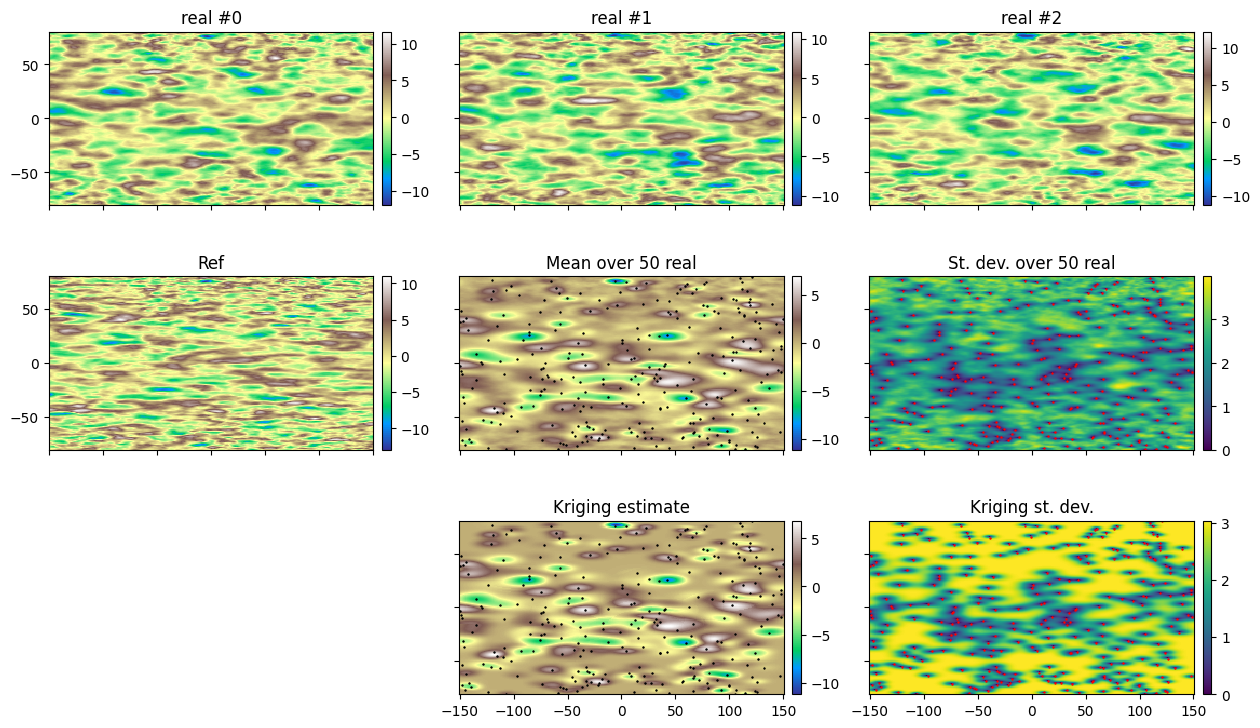

In [32]:
cmap = 'terrain'

# Plot
fig, ax = plt.subplots(3, 3, figsize=(15, 9), sharex=True, sharey=True)

# 3 first real ...
for i in (0, 1, 2):
    plt.subplot(3, 3, i+1)
    gn.imgplot.drawImage2D(simul, iv=i, cmap=cmap)
    #plt.plot(x[:,0],x[:,1], '+', c='black', markersize=10) # add conditioning point locations
    plt.title('real #{}'.format(i))

# ref 
plt.subplot(3, 3, 4)
gn.imgplot.drawImage2D(im_ref, cmap=cmap)
#plt.plot(x[:,0],x[:,1], '+', c='black', markersize=10) # add conditioning point locations
plt.title('Ref')

# mean of all real
plt.subplot(3, 3, 5)
gn.imgplot.drawImage2D(simul_mean, cmap=cmap)
plt.plot(x[:,0],x[:,1], '+', c='black', markersize=2) # add conditioning point locations
plt.title('Mean over {} real'.format(nreal))

# standard deviation of all real
plt.subplot(3, 3, 6)
gn.imgplot.drawImage2D(simul_std, cmap='viridis')
plt.plot(x[:,0],x[:,1], '+', c='red', markersize=2) # add conditioning point locations
plt.title('St. dev. over {} real'.format(nreal))

plt.subplot(3, 3, 7)
plt.axis('off')

# kriging estimate
plt.subplot(3, 3, 8)
gn.imgplot.drawImage2D(im_krig, iv=0, cmap=cmap)
plt.plot(x[:,0],x[:,1], '+', c='black', markersize=2) # add conditioning point locations
plt.title('Kriging estimate')

# kriging standard deviation
plt.subplot(3, 3, 9)
gn.imgplot.drawImage2D(im_krig, iv=1, cmap='viridis')
plt.plot(x[:,0],x[:,1], '+', c='red', markersize=2) # add conditioning point locations
plt.title('Kriging st. dev.')

plt.show()

## B2. Non-stationary range along 1st axis only

### Reference covariance model and non-stationarity
Define first a *stationary* anisotropic reference covariance model in 2D. Then, add the desired non-stationarity feature.

In [33]:
# Define a reference covariance model (stationary)
cov_model_ref = gn.covModel.CovModel2D(elem=[
    ('cubic', {'w':10, 'r':[30., 5.]}), # elementary contribution
    ], alpha=0.0, name='ref')

# Define the reference non-stationary covariance model
#   - Set locally varying ranges: range factor in the grid
cov_model_loc_ref = gn.covModel.copyCovModel(cov_model_ref)
cov_model_loc_ref.multiply_r(im_r_factor.val[0], r_ind=0) # range along 1st main axis only and of every contribution will be multiplied

### Do an unconditional simulation (reference)

Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20230914 / OpenMP 8 thread(s)]
Geos-Classic run complete

Warnings encountered (6 times in all):
#  1: WARNING 02001: a neigbhor has been dropped (solving kriging system)


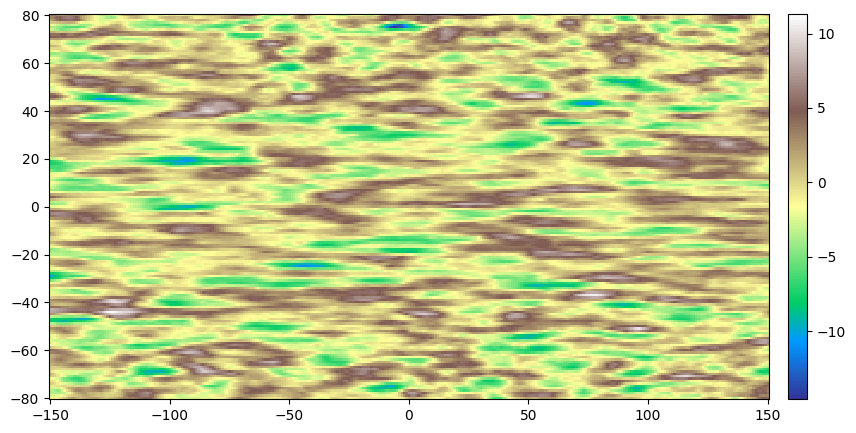

In [34]:
# Simulation
nreal = 1
np.random.seed(85)
geosclassic_output = gn.geosclassicinterface.simulate2D(cov_model_loc_ref, (nx, ny), (sx, sy), (ox, oy), 
                                                        method='simple_kriging', nneighborMax=20, nreal=nreal, 
                                                        nthreads=8)

im_ref = geosclassic_output['image']

plt.figure(figsize=(15,5))
gn.imgplot.drawImage2D(im_ref, cmap='terrain')
plt.show()

### Build a non-stationary data set (2D)

The data set is defined by extracting some points from the simulation of reference.

*Note:* the data set should contain enough points to catch the non-stationarities.

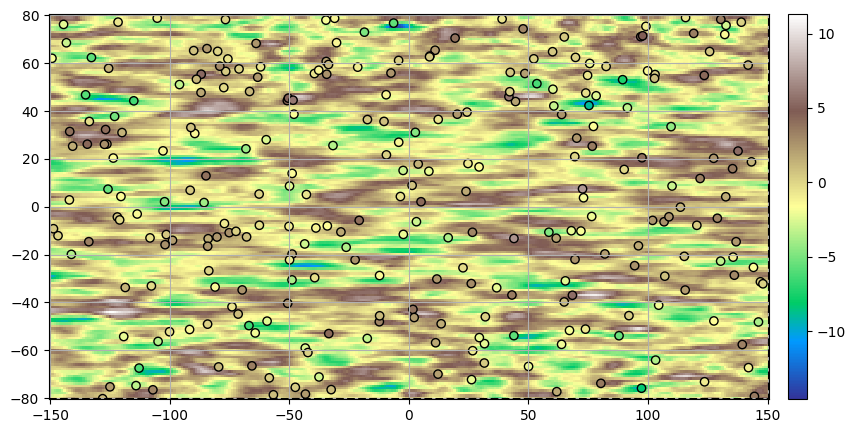

In [35]:
# Extract som points from the simulation
n = 280

# --- Choose 1. or 2. below ---
# # 1. Sampling the image
# ps = gn.img.sampleFromImage(im_ref, n, seed=234)
# # Data points and data value
# x = np.array((ps.x(), ps.y())).T
# v = ps.val[3]
# # Optionally: move points in the grid cells randomly, and add noise to values
# x[:, 0] = x[:, 0] + (np.random.random(n)-0.5)* im_ref.sx
# x[:, 1] = x[:, 1] + (np.random.random(n)-0.5)* im_ref.sy
# v = v + (np.random.random(n)-0.5)* 1.e-1

# 2. Using the function interpolating the image values
f = gn.img.Img_interp_func(im_ref, iz=0)
np.random.seed(864)
x1 = im_ref.xmin() + np.random.random(n) * (im_ref.xmax()-im_ref.xmin())
x2 = im_ref.ymin() + np.random.random(n) * (im_ref.ymax()-im_ref.ymin())
x = np.array((x1, x2)).T
v = f(x)
# ----- #

plt.figure(figsize=(15,5))
gn.imgplot.drawImage2D(im_ref, cmap='terrain')

plt.scatter(x[:,0], x[:,1], c=v, edgecolors='black', cmap='terrain', vmin=im_ref.vmin()[0], vmax=im_ref.vmax()[0])
plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], ls='dashed', c='black')
#plt.colorbar()
plt.axis('equal')
plt.grid()
plt.show()

### Simulation starting from a non-stationary data set in 2D and assuming "non-stationarity feature(s)" known
- `n`: number of data points,
- `x`: location of data points (2-dimensional array of shape `(n, 2)`, each row is a point),
- `v`: values at data points (1-dimensional array of length `n`),
- `im_r_factor`: image of the factor (multiplier) `r_factor` in the grid; the function `r_factor_inv_loc_func` (interpolator of the inverse of `r_factor` in the grid) is built from this image.

In [36]:
# Set a function interpolating the inverse of the r_factor (given location)
im_tmp = gn.img.copyImg(im_r_factor)
im_tmp.val = 1.0/im_tmp.val
r_factor_inv_loc_func = gn.img.Img_interp_func(im_tmp, ind=0, iz=0) # Specify iz=0: consider only x, and y coordinates in the layer iz=0

### Fitting covariance model accounting for non-stationarity

In [37]:
cov_model_to_optimize = gn.covModel.CovModel2D(elem=[
        ('cubic', {'w':np.nan, 'r':[np.nan, np.nan]}), # elementary contribution
         ], alpha=0.0, name='')

t1 = time.time()
cov_model_opt, popt = gn.covModel.covModel2D_fit(x, v, cov_model_to_optimize, 
                coord1_factor_loc_func=r_factor_inv_loc_func, coord2_factor_loc_func=None, 
                                                 # deal with non-stationarity (multiplier for range along 1st axis only)
                loc_m=0, # loc_m > 0: number of sub-intervals btw pair of points to estimate local function (default 1)
                         # loc_m = 0: take factor from one point
                bounds=([ 0,  0,  0],  # min value for param. to fit
                        [40, 80, 80]), # max value for param. to fit
                hmax=None, make_plot=False) # figure size for plot
t2 = time.time()
print(f'Fitting covariance model - elapsed time: {t2-t1:.4g}')

cov_model_opt

Fitting covariance model - elapsed time: 0.07192


*** CovModel2D object ***
name = ''
number of elementary contribution(s): 1
elementary contribution 0
    type: cubic
    parameters:
        w = 7.926493187067288
        r = [39.36216386898999, 5.872670013083376]
angle: alpha = 0.0 deg.
    i.e.: the system Ox'y', supporting the axes of the model (ranges),
    is obtained from the system Oxy by applying a rotation of angle -alpha.
*****

### Show experimental variogram, fitted model and reference model

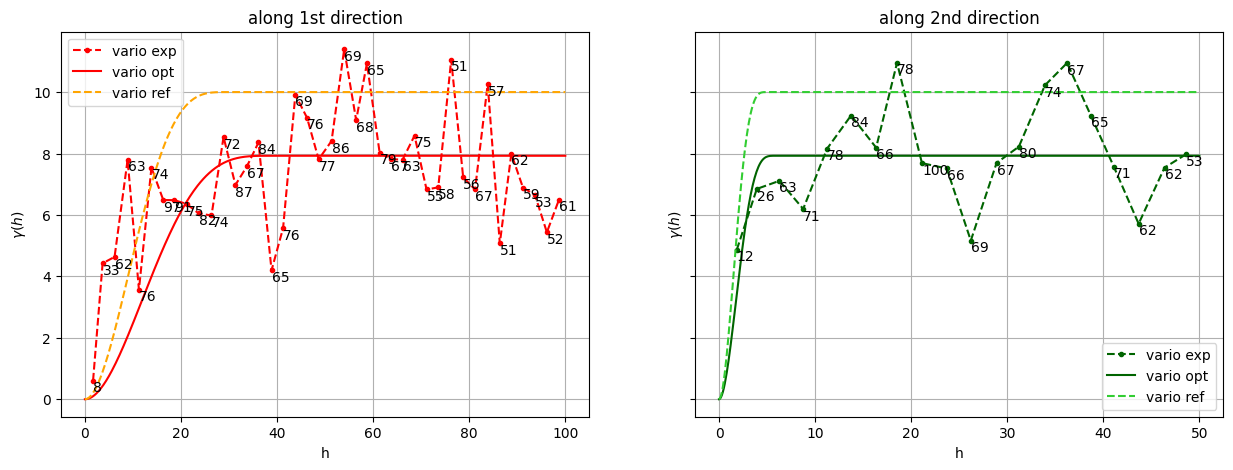

In [38]:
hmax1, hmax2 = 100.0, 50.0

(hexp1, gexp1, cexp1), (hexp2, gexp2, cexp2) = gn.covModel.variogramExp2D(
                x, v, alpha=0, hmax=(hmax1, hmax2), 
                coord1_factor_loc_func=r_factor_inv_loc_func, coord2_factor_loc_func=None, loc_m=0,
                ncla=(40, 20), make_plot=False)

plt.subplots(1,2, sharey=True, figsize=(15,5))
plt.subplot(1,2,1)
gn.covModel.plot_variogramExp1D(hexp1, gexp1, cexp1, c='red', label='vario exp')
cov_model_opt.plot_model_one_curve(vario=True, main_axis=1, hmax=hmax1, c='red', label='vario opt')
cov_model_ref.plot_model_one_curve(vario=True, main_axis=1, hmax=hmax1, c='orange', ls='dashed', label='vario ref')
plt.legend()
plt.title("along 1st direction")

plt.subplot(1,2,2)
gn.covModel.plot_variogramExp1D(hexp2, gexp2, cexp2, c='darkgreen', label='vario exp')
cov_model_opt.plot_model_one_curve(vario=True, main_axis=2, hmax=hmax2, c='darkgreen', label='vario opt')
cov_model_ref.plot_model_one_curve(vario=True, main_axis=2, hmax=hmax2, c='limegreen', ls='dashed', label='vario ref')
plt.legend()
plt.title("along 2nd direction")

plt.show()

### Set non-stationarity covariance model

In [39]:
# Define the non-stationary covariance model
cov_model_loc_opt = gn.covModel.copyCovModel(cov_model_opt)
cov_model_loc_opt.multiply_r(im_r_factor.val[0], r_ind=0)

### Kriging and conditional simulations

In [40]:
# Kriging
t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.estimate2D(cov_model_loc_opt, (nx, ny), (sx, sy), (ox, oy), 
                                                        x=x, v=v, method='simple_kriging', nneighborMax=20,
                                                        nthreads=8)
t2 = time.time() # end time
print(f'Kriging - elapsed time: {t2-t1:.4g} sec')

# Retrieve kriging estimate and standard deviation
im_krig = geosclassic_output['image']

Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20230914 / OpenMP 8 thread(s)]
Geos-Classic run complete

Warnings encountered (204 times in all):
#  1: WARNING 00041: conditioning value(s) has(have) been ignored from data point set (more than one datum in the same simulation grid node!)
#  2: WARNING 02001: a neigbhor has been dropped (solving kriging system)
Kriging - elapsed time: 0.03571 sec


In [41]:
# Simulation
nreal = 50
np.random.seed(22131)
t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.simulate2D_mp(cov_model_loc_opt, (nx, ny), (sx, sy), (ox, oy), 
                                                           x=x, v=v, method='simple_kriging', nneighborMax=20, nreal=nreal,
                                                           nproc=4, nthreads_per_proc=4)
t2 = time.time() # end time
print(f'{nreal} simul. - elapsed time: {t2-t1:.4g} sec')

# Retrieve the realizations
simul = geosclassic_output['image']

# Compute mean and standard deviation (pixel-wise)
simul_mean = gn.img.imageContStat(simul, op='mean')
simul_std = gn.img.imageContStat(simul, op='std')

Geos-Classic running on 4 process(es)... [VERSION 2.0 / BUILD NUMBER 20230914 / OpenMP 4 thread(s)]
Geos-Classic run complete (all process(es))

Warnings encountered (50 times in all):
#  1: WARNING 00041: conditioning value(s) has(have) been ignored from data point set (more than one datum in the same simulation grid node!)
#  2: WARNING 02001: a neigbhor has been dropped (solving kriging system)
50 simul. - elapsed time: 7.642 sec


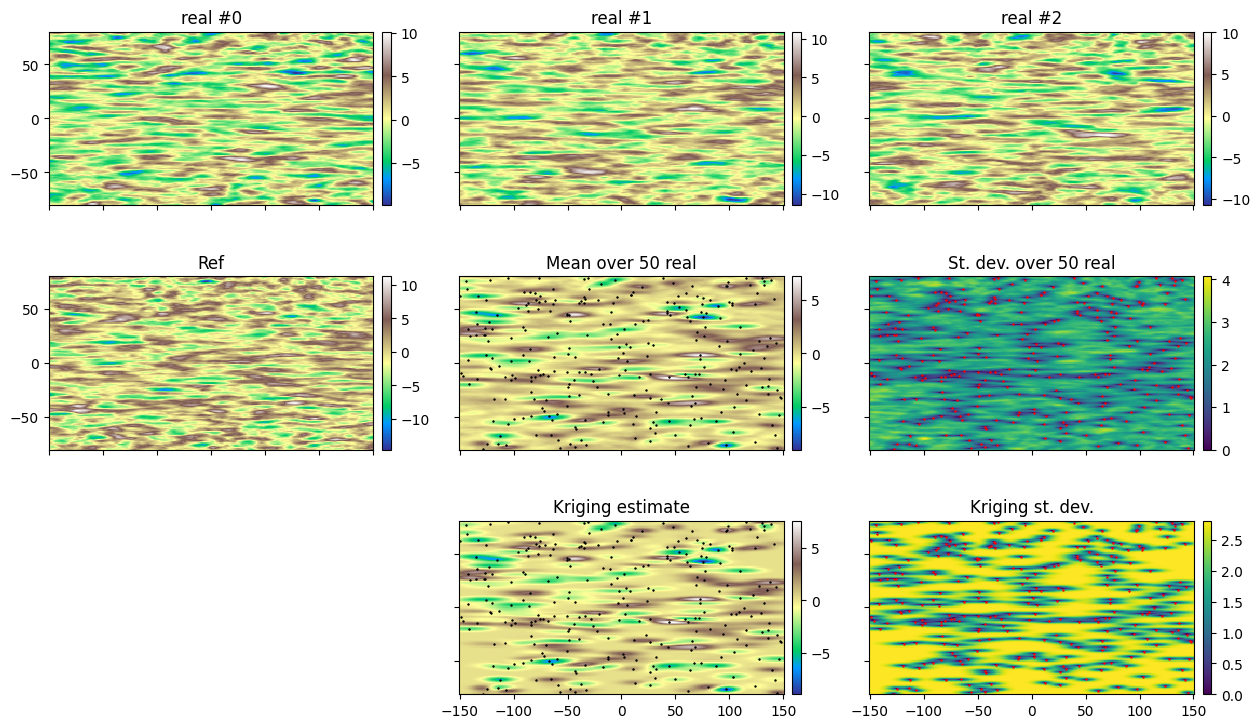

In [42]:
cmap = 'terrain'

# Plot
fig, ax = plt.subplots(3, 3, figsize=(15, 9), sharex=True, sharey=True)

# 3 first real ...
for i in (0, 1, 2):
    plt.subplot(3, 3, i+1)
    gn.imgplot.drawImage2D(simul, iv=i, cmap=cmap)
    #plt.plot(x[:,0],x[:,1], '+', c='black', markersize=10) # add conditioning point locations
    plt.title('real #{}'.format(i))

# ref 
plt.subplot(3, 3, 4)
gn.imgplot.drawImage2D(im_ref, cmap=cmap)
#plt.plot(x[:,0],x[:,1], '+', c='black', markersize=10) # add conditioning point locations
plt.title('Ref')

# mean of all real
plt.subplot(3, 3, 5)
gn.imgplot.drawImage2D(simul_mean, cmap=cmap)
plt.plot(x[:,0],x[:,1], '+', c='black', markersize=2) # add conditioning point locations
plt.title('Mean over {} real'.format(nreal))

# standard deviation of all real
plt.subplot(3, 3, 6)
gn.imgplot.drawImage2D(simul_std, cmap='viridis')
plt.plot(x[:,0],x[:,1], '+', c='red', markersize=2) # add conditioning point locations
plt.title('St. dev. over {} real'.format(nreal))

plt.subplot(3, 3, 7)
plt.axis('off')

# kriging estimate
plt.subplot(3, 3, 8)
gn.imgplot.drawImage2D(im_krig, iv=0, cmap=cmap)
plt.plot(x[:,0],x[:,1], '+', c='black', markersize=2) # add conditioning point locations
plt.title('Kriging estimate')

# kriging standard deviation
plt.subplot(3, 3, 9)
gn.imgplot.drawImage2D(im_krig, iv=1, cmap='viridis')
plt.plot(x[:,0],x[:,1], '+', c='red', markersize=2) # add conditioning point locations
plt.title('Kriging st. dev.')

plt.show()

## C. Non-stationary variance (sill)

### Reference covariance model and non-stationarity
Define first a *stationary* anisotropic reference covariance model in 2D. Then, add the desired non-stationarity feature.

In [43]:
# Define a reference covariance model (stationary)
cov_model_ref = gn.covModel.CovModel2D(elem=[
    ('cubic', {'w':10, 'r':[30., 5.]}), # elementary contribution
    ], alpha=0.0, name='ref')

# Define the reference non-stationary covariance model
#   - Set locally varying weight (sill): weight factor in the grid
cov_model_loc_ref = gn.covModel.copyCovModel(cov_model_ref)
cov_model_loc_ref.multiply_w(im_w_factor.val[0]) # weight of every contribution will be multiplied

### Do an unconditional simulation (reference)

Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20230914 / OpenMP 8 thread(s)]
Geos-Classic run complete


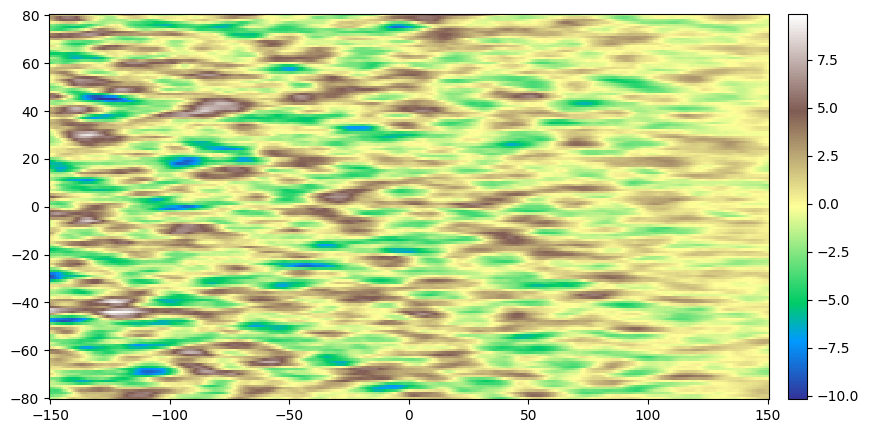

In [44]:
# Simulation
nreal = 1
np.random.seed(85)
geosclassic_output = gn.geosclassicinterface.simulate2D(cov_model_loc_ref, (nx, ny), (sx, sy), (ox, oy), 
                                                        method='simple_kriging', nneighborMax=20, nreal=nreal, 
                                                        nthreads=8)

im_ref = geosclassic_output['image']

plt.figure(figsize=(15,5))
gn.imgplot.drawImage2D(im_ref, cmap='terrain')
plt.show()

### Build a non-stationary data set (2D)

The data set is defined by extracting some points from the simulation of reference.

*Note:* the data set should contain enough points to catch the non-stationarities.

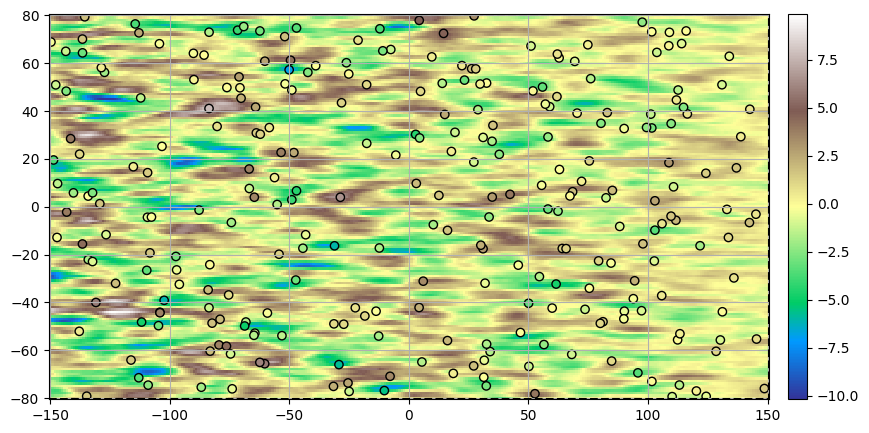

In [45]:
# Extract som points from the simulation
n = 280

# --- Choose 1. or 2. below ---
# # 1. Sampling the image
# ps = gn.img.sampleFromImage(im_ref, n, seed=234)
# # Data points and data value
# x = np.array((ps.x(), ps.y())).T
# v = ps.val[3]
# # Optionally: move points in the grid cells randomly, and add noise to values
# x[:, 0] = x[:, 0] + (np.random.random(n)-0.5)* im_ref.sx
# x[:, 1] = x[:, 1] + (np.random.random(n)-0.5)* im_ref.sy
# v = v + (np.random.random(n)-0.5)* 1.e-1

# 2. Using the function interpolating the image values
f = gn.img.Img_interp_func(im_ref, iz=0)
np.random.seed(9826)
x1 = im_ref.xmin() + np.random.random(n) * (im_ref.xmax()-im_ref.xmin())
x2 = im_ref.ymin() + np.random.random(n) * (im_ref.ymax()-im_ref.ymin())
x = np.array((x1, x2)).T
v = f(x)
# ----- #

plt.figure(figsize=(15,5))
gn.imgplot.drawImage2D(im_ref, cmap='terrain')

plt.scatter(x[:,0], x[:,1], c=v, edgecolors='black', cmap='terrain', vmin=im_ref.vmin()[0], vmax=im_ref.vmax()[0])
plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], ls='dashed', c='black')
#plt.colorbar()
plt.axis('equal')
plt.grid()
plt.show()

### Simulation starting from a non-stationary data set in 2D and assuming "non-stationarity feature(s)" known
- `n`: number of data points,
- `x`: location of data points (2-dimensional array of shape `(n, 2)`, each row is a point),
- `v`: values at data points (1-dimensional array of length `n`),
- `im_w_factor`: image of the factor (multiplier) `w_factor` in the grid; the function `w_factor_inv_loc_func` (interpolator of the inverse of `w_factor` in the grid) is built from this image.

In [46]:
# Set a function interpolating the inverse of the w_factor (given location)
im_tmp = gn.img.copyImg(im_w_factor)
im_tmp.val = 1.0/im_tmp.val
w_factor_inv_loc_func = gn.img.Img_interp_func(im_tmp, ind=0, iz=0) # Specify iz=0: consider only x, and y coordinates in the layer iz=0

### Fitting covariance model accounting for non-stationarity

In [47]:
cov_model_to_optimize = gn.covModel.CovModel2D(elem=[
        ('cubic', {'w':np.nan, 'r':[np.nan, np.nan]}), # elementary contribution
         ], alpha=0.0, name='')

t1 = time.time()
cov_model_opt, popt = gn.covModel.covModel2D_fit(x, v, cov_model_to_optimize, 
                w_factor_loc_func=w_factor_inv_loc_func, # deal with non-stationarity (multiplier for weight)
                loc_m=0, # loc_m > 0: number of sub-intervals btw pair of points to estimate local function (default 1)
                         # loc_m = 0: take factor from one point
                bounds=([ 0,  0,  0],  # min value for param. to fit
                        [40, 80, 80]), # max value for param. to fit
                hmax=None, make_plot=False) # figure size for plot
t2 = time.time()
print(f'Fitting covariance model - elapsed time: {t2-t1:.4g}')

cov_model_opt

Fitting covariance model - elapsed time: 0.07101


*** CovModel2D object ***
name = ''
number of elementary contribution(s): 1
elementary contribution 0
    type: cubic
    parameters:
        w = 11.6821521977696
        r = [36.995943145070434, 5.893203612927041]
angle: alpha = 0.0 deg.
    i.e.: the system Ox'y', supporting the axes of the model (ranges),
    is obtained from the system Oxy by applying a rotation of angle -alpha.
*****

### Show experimental variogram, fitted model and reference model

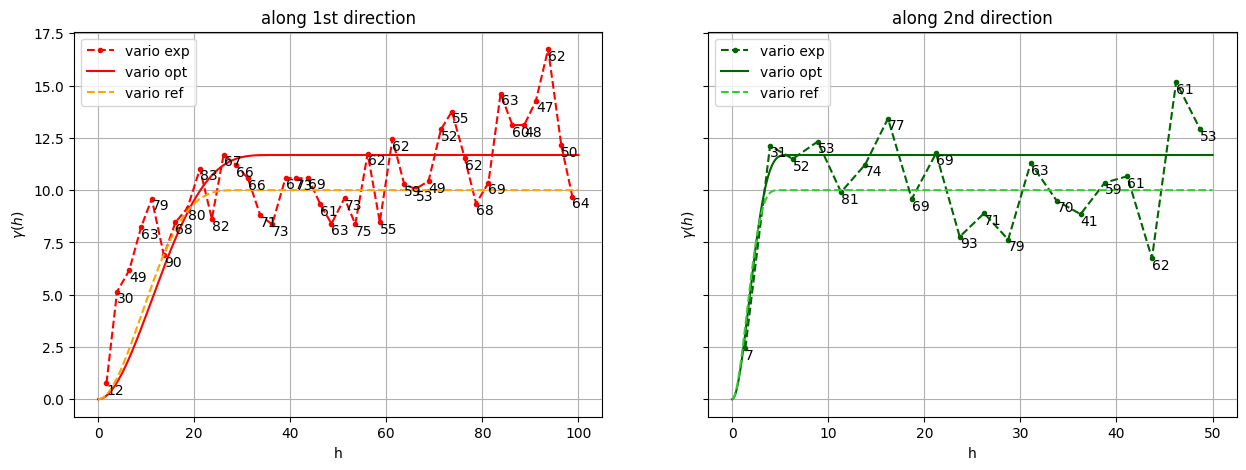

In [48]:
hmax1, hmax2 = 100.0, 50.0

(hexp1, gexp1, cexp1), (hexp2, gexp2, cexp2) = gn.covModel.variogramExp2D(
                x, v, alpha=0, hmax=(hmax1, hmax2), 
                w_factor_loc_func=w_factor_inv_loc_func, loc_m=0,
                ncla=(40, 20), make_plot=False)

plt.subplots(1,2, sharey=True, figsize=(15,5))
plt.subplot(1,2,1)
gn.covModel.plot_variogramExp1D(hexp1, gexp1, cexp1, c='red', label='vario exp')
cov_model_opt.plot_model_one_curve(vario=True, main_axis=1, hmax=hmax1, c='red', label='vario opt')
cov_model_ref.plot_model_one_curve(vario=True, main_axis=1, hmax=hmax1, c='orange', ls='dashed', label='vario ref')
plt.legend()
plt.title("along 1st direction")

plt.subplot(1,2,2)
gn.covModel.plot_variogramExp1D(hexp2, gexp2, cexp2, c='darkgreen', label='vario exp')
cov_model_opt.plot_model_one_curve(vario=True, main_axis=2, hmax=hmax2, c='darkgreen', label='vario opt')
cov_model_ref.plot_model_one_curve(vario=True, main_axis=2, hmax=hmax2, c='limegreen', ls='dashed', label='vario ref')
plt.legend()
plt.title("along 2nd direction")

plt.show()

### Set non-stationarity covariance model

In [49]:
# Define the non-stationary covariance model
cov_model_loc_opt = gn.covModel.copyCovModel(cov_model_opt)
cov_model_loc_opt.multiply_w(im_w_factor.val[0])

### Kriging and conditional simulations

In [50]:
# Kriging
t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.estimate2D(cov_model_loc_opt, (nx, ny), (sx, sy), (ox, oy), 
                                                        x=x, v=v, method='simple_kriging', nneighborMax=20,
                                                        nthreads=8)
t2 = time.time() # end time
print(f'Kriging - elapsed time: {t2-t1:.4g} sec')

# Retrieve kriging estimate and standard deviation
im_krig = geosclassic_output['image']

Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20230914 / OpenMP 8 thread(s)]
Geos-Classic run complete

Warnings encountered (1 times in all):
#  1: WARNING 00041: conditioning value(s) has(have) been ignored from data point set (more than one datum in the same simulation grid node!)
Kriging - elapsed time: 0.02434 sec


In [51]:
# Simulation
nreal = 50
np.random.seed(22131)
t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.simulate2D_mp(cov_model_loc_opt, (nx, ny), (sx, sy), (ox, oy), 
                                                           x=x, v=v, method='simple_kriging', nneighborMax=20, nreal=nreal,
                                                           nproc=4, nthreads_per_proc=4)
t2 = time.time() # end time
print(f'{nreal} simul. - elapsed time: {t2-t1:.4g} sec')

# Retrieve the realizations
simul = geosclassic_output['image']

# Compute mean and standard deviation (pixel-wise)
simul_mean = gn.img.imageContStat(simul, op='mean')
simul_std = gn.img.imageContStat(simul, op='std')

Geos-Classic running on 4 process(es)... [VERSION 2.0 / BUILD NUMBER 20230914 / OpenMP 4 thread(s)]
Geos-Classic run complete (all process(es))

Warnings encountered (4 times in all):
#  1: WARNING 00041: conditioning value(s) has(have) been ignored from data point set (more than one datum in the same simulation grid node!)
50 simul. - elapsed time: 6.557 sec


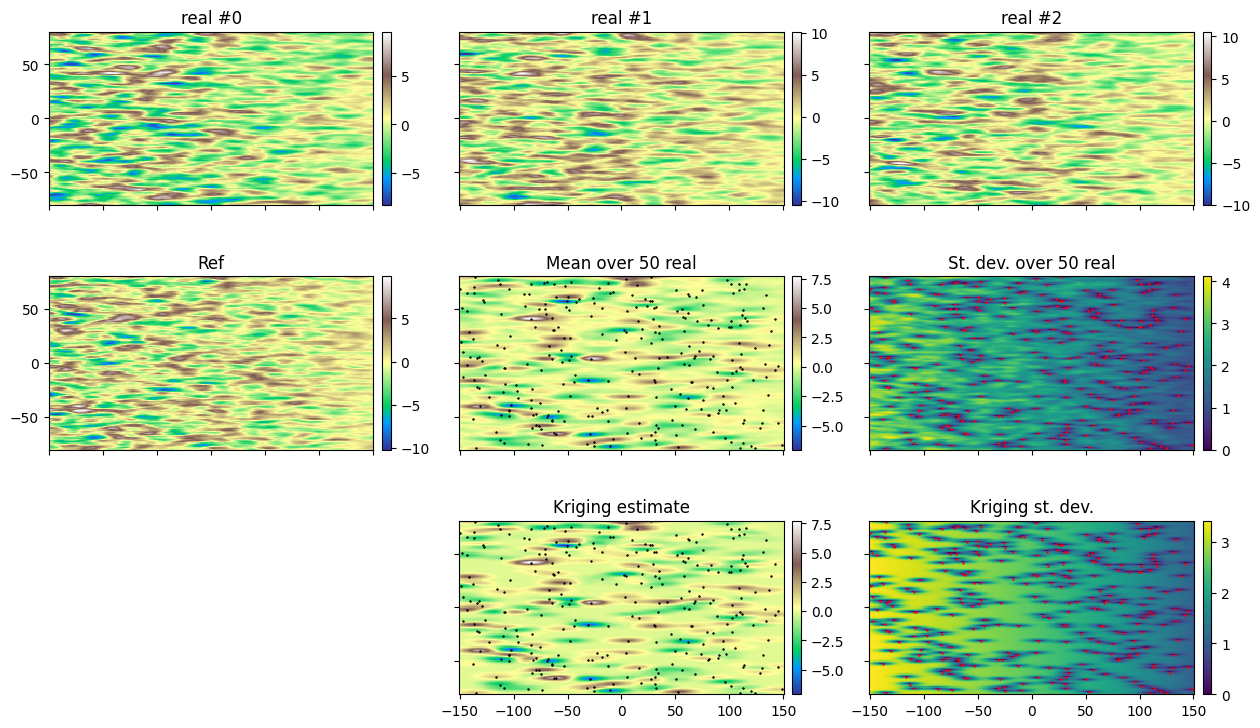

In [52]:
cmap = 'terrain'

# Plot
fig, ax = plt.subplots(3, 3, figsize=(15, 9), sharex=True, sharey=True)

# 3 first real ...
for i in (0, 1, 2):
    plt.subplot(3, 3, i+1)
    gn.imgplot.drawImage2D(simul, iv=i, cmap=cmap)
    #plt.plot(x[:,0],x[:,1], '+', c='black', markersize=10) # add conditioning point locations
    plt.title('real #{}'.format(i))

# ref 
plt.subplot(3, 3, 4)
gn.imgplot.drawImage2D(im_ref, cmap=cmap)
#plt.plot(x[:,0],x[:,1], '+', c='black', markersize=10) # add conditioning point locations
plt.title('Ref')

# mean of all real
plt.subplot(3, 3, 5)
gn.imgplot.drawImage2D(simul_mean, cmap=cmap)
plt.plot(x[:,0],x[:,1], '+', c='black', markersize=2) # add conditioning point locations
plt.title('Mean over {} real'.format(nreal))

# standard deviation of all real
plt.subplot(3, 3, 6)
gn.imgplot.drawImage2D(simul_std, cmap='viridis')
plt.plot(x[:,0],x[:,1], '+', c='red', markersize=2) # add conditioning point locations
plt.title('St. dev. over {} real'.format(nreal))

plt.subplot(3, 3, 7)
plt.axis('off')

# kriging estimate
plt.subplot(3, 3, 8)
gn.imgplot.drawImage2D(im_krig, iv=0, cmap=cmap)
plt.plot(x[:,0],x[:,1], '+', c='black', markersize=2) # add conditioning point locations
plt.title('Kriging estimate')

# kriging standard deviation
plt.subplot(3, 3, 9)
gn.imgplot.drawImage2D(im_krig, iv=1, cmap='viridis')
plt.plot(x[:,0],x[:,1], '+', c='red', markersize=2) # add conditioning point locations
plt.title('Kriging st. dev.')

plt.show()

## D. Non-stationary for orientation, ranges and variance (sill)

Note that the ranges are expressed in local axes, which are locally varying when non-stationary orientation is specified.

### Reference covariance model and non-stationarity
Define first a *stationary* anisotropic reference covariance model in 2D. Then, add the desired non-stationarity feature.

In [53]:
# Define a reference covariance model (stationary)
cov_model_ref = gn.covModel.CovModel2D(elem=[
    ('cubic', {'w':10, 'r':[30., 5.]}), # elementary contribution
    ], alpha=0.0, name='ref')

# Define the reference non-stationary covariance model
#   - Set locally varying angle: alpha in the grid
#   - Set locally varying ranges: range factor in the grid
#   - Set locally varying weight (sill): weight factor in the grid
cov_model_loc_ref = gn.covModel.copyCovModel(cov_model_ref)
cov_model_loc_ref.set_alpha(im_alpha.val[0])
cov_model_loc_ref.multiply_r(im_r_factor.val[0], r_ind=(0, 1)) # range along each axis and of every contribution will be multiplied
cov_model_loc_ref.multiply_w(im_w_factor.val[0]) # weight of every contribution will be multiplied

### Do an unconditional simulation (reference)

Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20230914 / OpenMP 8 thread(s)]
Geos-Classic run complete

Warnings encountered (81 times in all):
#  1: WARNING 02001: a neigbhor has been dropped (solving kriging system)


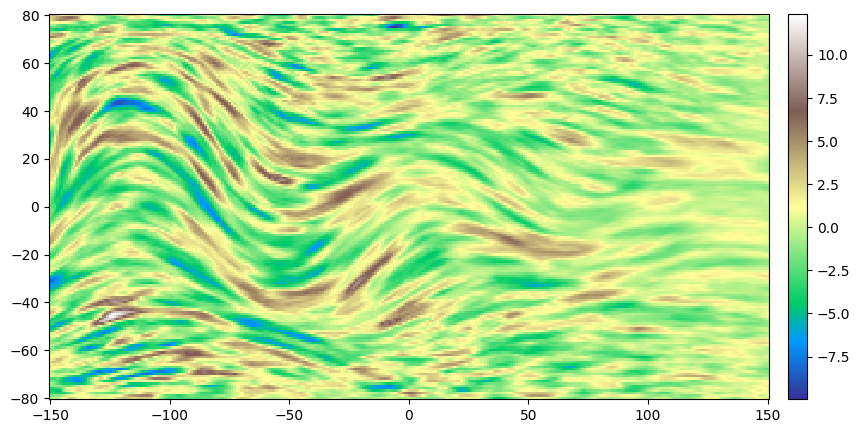

In [54]:
# Simulation
nreal = 1
np.random.seed(85)
geosclassic_output = gn.geosclassicinterface.simulate2D(cov_model_loc_ref, (nx, ny), (sx, sy), (ox, oy), 
                                                        method='simple_kriging', nneighborMax=20, nreal=nreal, 
                                                        nthreads=8)

im_ref = geosclassic_output['image']

plt.figure(figsize=(15,5))
gn.imgplot.drawImage2D(im_ref, cmap='terrain')
plt.show()

### Build a non-stationary data set (2D)

The data set is defined by extracting some points from the simulation of reference.

*Note:* the data set should contain enough points to catch the non-stationarities.

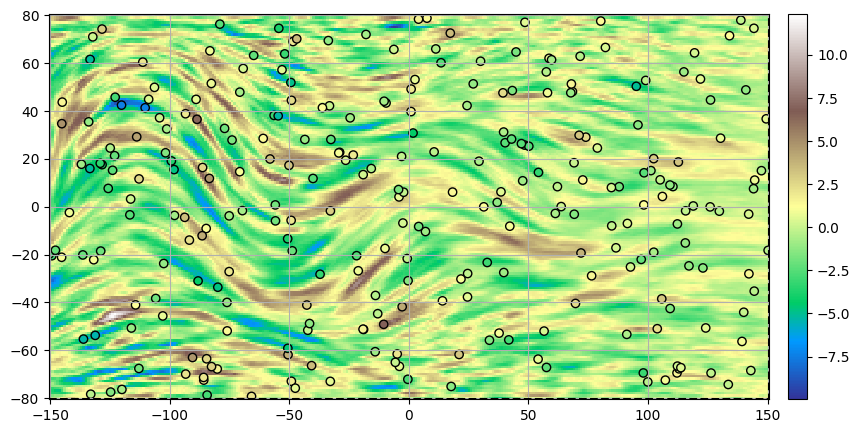

In [55]:
# Extract som points from the simulation
n = 280

# --- Choose 1. or 2. below ---
# # 1. Sampling the image
# ps = gn.img.sampleFromImage(im_ref, n, seed=234)
# # Data points and data value
# x = np.array((ps.x(), ps.y())).T
# v = ps.val[3]
# # Optionally: move points in the grid cells randomly, and add noise to values
# x[:, 0] = x[:, 0] + (np.random.random(n)-0.5)* im_ref.sx
# x[:, 1] = x[:, 1] + (np.random.random(n)-0.5)* im_ref.sy
# v = v + (np.random.random(n)-0.5)* 1.e-1

# 2. Using the function interpolating the image values
f = gn.img.Img_interp_func(im_ref, iz=0)
np.random.seed(4287)
x1 = im_ref.xmin() + np.random.random(n) * (im_ref.xmax()-im_ref.xmin())
x2 = im_ref.ymin() + np.random.random(n) * (im_ref.ymax()-im_ref.ymin())
x = np.array((x1, x2)).T
v = f(x)
# ----- #

plt.figure(figsize=(15,5))
gn.imgplot.drawImage2D(im_ref, cmap='terrain')

plt.scatter(x[:,0], x[:,1], c=v, edgecolors='black', cmap='terrain', vmin=im_ref.vmin()[0], vmax=im_ref.vmax()[0])
plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], ls='dashed', c='black')
#plt.colorbar()
plt.axis('equal')
plt.grid()
plt.show()

### Simulation starting from a non-stationary data set in 2D and assuming "non-stationarity feature(s)" known
- `n`: number of data points,
- `x`: location of data points (2-dimensional array of shape `(n, 2)`, each row is a point),
- `v`: values at data points (1-dimensional array of length `n`),
- `im_alpha`: image of the angle `alpha` in the grid; the function `alpha_loc_func` (interpolator of `alpha` in the grid) is built from this image,
- `im_r_factor`: image of the factor (multiplier) `r_factor` in the grid; the function `r_factor_inv_loc_func` (interpolator of the inverse of `r_factor` in the grid) is built from this image,
- `im_w_factor`: image of the factor (multiplier) `w_factor` in the grid; the function `w_factor_inv_loc_func` (interpolator of the inverse of `w_factor` in the grid) is built from this image.

In [56]:
# Set a function interpolating the alpha (given location)
alpha_loc_func = gn.img.Img_interp_func(im_alpha, ind=0, iz=0) # Specify iz=0: consider only x, and y coordinates in the layer iz=0

# Set a function interpolating the inverse of the r_factor (given location)
im_tmp = gn.img.copyImg(im_r_factor)
im_tmp.val = 1.0/im_tmp.val
r_factor_inv_loc_func = gn.img.Img_interp_func(im_tmp, ind=0, iz=0) # Specify iz=0: consider only x, and y coordinates in the layer iz=0

# Set a function interpolating the inverse of the w_factor (given location)
im_tmp = gn.img.copyImg(im_w_factor)
im_tmp.val = 1.0/im_tmp.val
w_factor_inv_loc_func = gn.img.Img_interp_func(im_tmp, ind=0, iz=0) # Specify iz=0: consider only x, and y coordinates in the layer iz=0

### Fitting covariance model accounting for non-stationarity

In [57]:
cov_model_to_optimize = gn.covModel.CovModel2D(elem=[
        ('cubic', {'w':np.nan, 'r':[np.nan, np.nan]}), # elementary contribution
         ], alpha=0.0, name='') # alpha is set to 0.0, non-sationarity is handled by alpha_loc_func below

t1 = time.time()
cov_model_opt, popt = gn.covModel.covModel2D_fit(x, v, cov_model_to_optimize,
                alpha_loc_func=alpha_loc_func, # deal with non-stationarity (angle alpha)
                coord1_factor_loc_func=r_factor_inv_loc_func, coord2_factor_loc_func=r_factor_inv_loc_func, 
                                                 # deal with non-stationarity (multiplier for range along each axis)
                w_factor_loc_func=w_factor_inv_loc_func, # deal with non-stationarity (multiplier for weight)
                loc_m=0, # loc_m > 0: number of sub-intervals btw pair of points to estimate local function (default 1)
                         # loc_m = 0: take factor from one point
                bounds=([ 0,  0,  0],  # min value for param. to fit
                        [40, 80, 80]), # max value for param. to fit
                hmax=None, make_plot=False) # figure size for plot
t2 = time.time()
print(f'Fitting covariance model - elapsed time: {t2-t1:.4g}')

cov_model_opt

Fitting covariance model - elapsed time: 0.08172


*** CovModel2D object ***
name = ''
number of elementary contribution(s): 1
elementary contribution 0
    type: cubic
    parameters:
        w = 10.021699417603935
        r = [33.14149064827072, 6.795590716664897]
angle: alpha = 0.0 deg.
    i.e.: the system Ox'y', supporting the axes of the model (ranges),
    is obtained from the system Oxy by applying a rotation of angle -alpha.
*****

### Show experimental variogram, fitted model and reference model

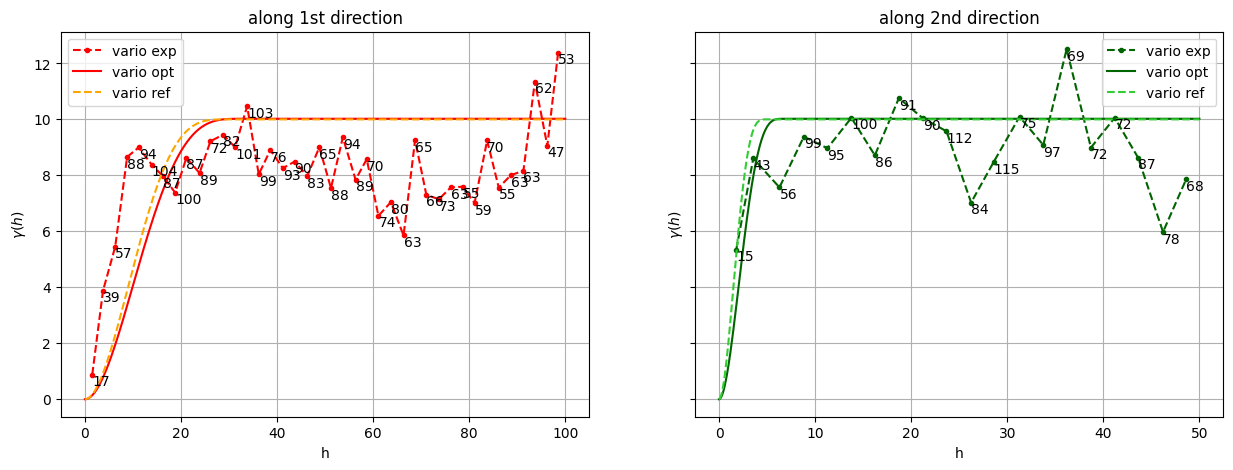

In [58]:
hmax1, hmax2 = 100.0, 50.0

(hexp1, gexp1, cexp1), (hexp2, gexp2, cexp2) = gn.covModel.variogramExp2D(
                x, v, alpha=0, hmax=(hmax1, hmax2), 
                alpha_loc_func=alpha_loc_func,
                coord1_factor_loc_func=r_factor_inv_loc_func, coord2_factor_loc_func=r_factor_inv_loc_func,
                w_factor_loc_func=w_factor_inv_loc_func, loc_m=0,
                ncla=(40, 20), make_plot=False)

plt.subplots(1,2, sharey=True, figsize=(15,5))
plt.subplot(1,2,1)
gn.covModel.plot_variogramExp1D(hexp1, gexp1, cexp1, c='red', label='vario exp')
cov_model_opt.plot_model_one_curve(vario=True, main_axis=1, hmax=hmax1, c='red', label='vario opt')
cov_model_ref.plot_model_one_curve(vario=True, main_axis=1, hmax=hmax1, c='orange', ls='dashed', label='vario ref')
plt.legend()
plt.title("along 1st direction")

plt.subplot(1,2,2)
gn.covModel.plot_variogramExp1D(hexp2, gexp2, cexp2, c='darkgreen', label='vario exp')
cov_model_opt.plot_model_one_curve(vario=True, main_axis=2, hmax=hmax2, c='darkgreen', label='vario opt')
cov_model_ref.plot_model_one_curve(vario=True, main_axis=2, hmax=hmax2, c='limegreen', ls='dashed', label='vario ref')
plt.legend()
plt.title("along 2nd direction")

plt.show()

### Set non-stationarity covariance model

In [59]:
# Define the non-stationary covariance model
cov_model_loc_opt = gn.covModel.copyCovModel(cov_model_opt)
cov_model_loc_opt.set_alpha(im_alpha.val[0])
cov_model_loc_opt.multiply_r(im_r_factor.val[0], r_ind=(0, 1))
cov_model_loc_opt.multiply_w(im_w_factor.val[0])

### Kriging and conditional simulations

In [60]:
# Kriging
t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.estimate2D(cov_model_loc_opt, (nx, ny), (sx, sy), (ox, oy), 
                                                        x=x, v=v, method='simple_kriging', nneighborMax=20,
                                                        nthreads=8)
t2 = time.time() # end time
print(f'Kriging - elapsed time: {t2-t1:.4g} sec')

# Retrieve kriging estimate and standard deviation
im_krig = geosclassic_output['image']

Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20230914 / OpenMP 8 thread(s)]
Geos-Classic run complete

Warnings encountered (3922 times in all):
#  1: WARNING 00041: conditioning value(s) has(have) been ignored from data point set (more than one datum in the same simulation grid node!)
#  2: WARNING 02001: a neigbhor has been dropped (solving kriging system)
Kriging - elapsed time: 0.2111 sec


In [61]:
# Simulation
nreal = 50
np.random.seed(22131)
t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.simulate2D_mp(cov_model_loc_opt, (nx, ny), (sx, sy), (ox, oy), 
                                                           x=x, v=v, method='simple_kriging', nneighborMax=20, nreal=nreal,
                                                           nproc=4, nthreads_per_proc=4)
t2 = time.time() # end time
print(f'{nreal} simul. - elapsed time: {t2-t1:.4g} sec')

# Retrieve the realizations
simul = geosclassic_output['image']

# Compute mean and standard deviation (pixel-wise)
simul_mean = gn.img.imageContStat(simul, op='mean')
simul_std = gn.img.imageContStat(simul, op='std')

Geos-Classic running on 4 process(es)... [VERSION 2.0 / BUILD NUMBER 20230914 / OpenMP 4 thread(s)]
Geos-Classic run complete (all process(es))

Warnings encountered (1164 times in all):
#  1: WARNING 00041: conditioning value(s) has(have) been ignored from data point set (more than one datum in the same simulation grid node!)
#  2: WARNING 02001: a neigbhor has been dropped (solving kriging system)
50 simul. - elapsed time: 7.977 sec


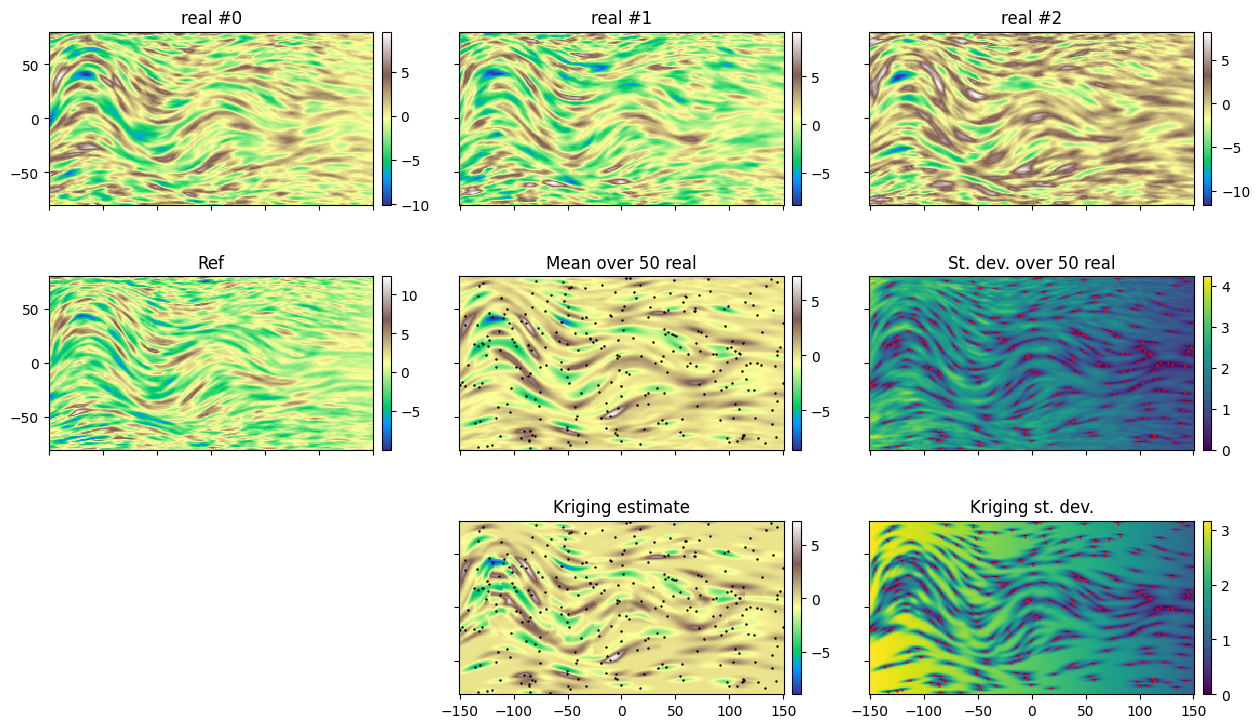

In [62]:
cmap = 'terrain'

# Plot
fig, ax = plt.subplots(3, 3, figsize=(15, 9), sharex=True, sharey=True)

# 3 first real ...
for i in (0, 1, 2):
    plt.subplot(3, 3, i+1)
    gn.imgplot.drawImage2D(simul, iv=i, cmap=cmap)
    #plt.plot(x[:,0],x[:,1], '+', c='black', markersize=10) # add conditioning point locations
    plt.title('real #{}'.format(i))

# ref 
plt.subplot(3, 3, 4)
gn.imgplot.drawImage2D(im_ref, cmap=cmap)
#plt.plot(x[:,0],x[:,1], '+', c='black', markersize=10) # add conditioning point locations
plt.title('Ref')

# mean of all real
plt.subplot(3, 3, 5)
gn.imgplot.drawImage2D(simul_mean, cmap=cmap)
plt.plot(x[:,0],x[:,1], '+', c='black', markersize=2) # add conditioning point locations
plt.title('Mean over {} real'.format(nreal))

# standard deviation of all real
plt.subplot(3, 3, 6)
gn.imgplot.drawImage2D(simul_std, cmap='viridis')
plt.plot(x[:,0],x[:,1], '+', c='red', markersize=2) # add conditioning point locations
plt.title('St. dev. over {} real'.format(nreal))

plt.subplot(3, 3, 7)
plt.axis('off')

# kriging estimate
plt.subplot(3, 3, 8)
gn.imgplot.drawImage2D(im_krig, iv=0, cmap=cmap)
plt.plot(x[:,0],x[:,1], '+', c='black', markersize=2) # add conditioning point locations
plt.title('Kriging estimate')

# kriging standard deviation
plt.subplot(3, 3, 9)
gn.imgplot.drawImage2D(im_krig, iv=1, cmap='viridis')
plt.plot(x[:,0],x[:,1], '+', c='red', markersize=2) # add conditioning point locations
plt.title('Kriging st. dev.')

plt.show()